In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from ydata_profiling import ProfileReport
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, make_scorer, roc_curve


from scipy.interpolate import interp1d
from sklearn.pipeline import Pipeline
from functools import partial
from sklearn.decomposition import PCA



pd.options.display.max_rows = None  # Show all rows
pd.options.display.max_columns = None  # Show all columns
pd.options.display.max_colwidth = None  # Ensure full content is visible
pd.set_option('display.float_format', '{:.6f}'.format)  # Adjust decimal places as needed

C:\Users\liuya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
cdc2023 = pd.read_csv(r"data_files\CDC_2023.csv")

In [4]:
# Obtaining features with missing values above 80%
nan_percent = 100 * cdc2023.isnull().sum() / len(cdc2023)
nan_percent = nan_percent[nan_percent > 0].sort_values(ascending=False)

nan_percent[nan_percent > 90]

WKENDOUT   100.000000
WKDAYOUT   100.000000
SUNPRTCT   100.000000
NUMBURN3   100.000000
INDORTAN   100.000000
COLGHOUS    99.997231
LASTSIG4    99.966307
LNDSXBRT    99.960999
CSRVCTL2    99.948768
VCLNTES2    99.921537
SDNATES1    99.882074
BLDSTFIT    99.881843
CRVCLHPV    99.865458
CRVCLPAP    99.864997
CRVCLCNC    99.864997
HOWLONG     99.789072
HADHYST2    99.750071
CERVSCRN    99.748686
HADMAM      99.747763
SIGMTES1    99.717070
CCLGHOUS    99.688223
CSRVINST    99.686146
CSRVCLIN    99.585759
CSRVDEIN    99.585298
CSRVINSR    99.584836
CSRVRTRN    99.583452
CSRVSUM     99.582990
CSRVDOC1    99.582759
LCSCTWHN    99.547682
STOLTEST    99.501296
HPVADSHT    99.471064
CELSXBRT    99.405063
STOOLDN2    99.402986
SMALSTOL    99.401140
VIRCOLO1    99.400447
RCSXBRTH    99.392139
CSRVPAIN    99.360062
CSRVTRT3    99.152826
IMFVPLA4    99.062362
CASTHNO2    98.904051
USEMRJN4    98.902897
LCSLAST     98.442732
NUMPHON4    98.307037
COLNTES1    98.280959
COLNSIGM    98.232958
LCSNUMCG  

In [5]:
features_over_80_missing = nan_percent[nan_percent > 95].index.tolist()

# Dropping Specified Columns
cdc2023.drop(columns=features_over_80_missing, axis=1, inplace=True)

In [6]:
len(cdc2023.columns)

263

In [7]:
features = sorted(cdc2023.columns)
features

['ACEADNED',
 'ACEADSAF',
 'ACEDEPRS',
 'ACEDIVRC',
 'ACEDRINK',
 'ACEDRUGS',
 'ACEHURT1',
 'ACEHVSEX',
 'ACEPRISN',
 'ACEPUNCH',
 'ACESWEAR',
 'ACETOUCH',
 'ACETTHEM',
 'ACTIN13_',
 'ACTIN23_',
 'ADDEPEV3',
 'ALCDAY4',
 'ARTHDIS2',
 'ARTHEDU',
 'ARTHEXER',
 'ASPIRIN',
 'ASTHMA3',
 'ASTHNOW',
 'AVEDRNK3',
 'BIRTHSEX',
 'BLIND',
 'BPHIGH6',
 'BPMEDS1',
 'CADULT1',
 'CAGEG',
 'CAREGIV1',
 'CASTHDX2',
 'CDDISCU1',
 'CDHOUS1',
 'CDSOCIA1',
 'CDWORRY',
 'CELLFON5',
 'CELLSEX2',
 'CELPHON1',
 'CHCCOPD3',
 'CHCKDNY2',
 'CHCOCNC1',
 'CHCSCNC1',
 'CHECKUP1',
 'CHILDREN',
 'CHKHEMO3',
 'CHOLCHK3',
 'CHOLMED3',
 'CIMEMLO1',
 'COVIDACT',
 'COVIDNU2',
 'COVIDPO1',
 'COVIDSM1',
 'COVIDVA1',
 'CPDEMO1C',
 'CRGVEXPT',
 'CSTATE1',
 'CTELENM1',
 'CTELNUM1',
 'CVDCRHD4',
 'CVDINFR4',
 'CVDSTRK3',
 'DEAF',
 'DECIDE',
 'DIABAGE4',
 'DIABEDU1',
 'DIABETE4',
 'DIABEYE1',
 'DIABTYPE',
 'DIFFALON',
 'DIFFDRES',
 'DIFFWALK',
 'DISPCODE',
 'DRNK3GE5',
 'DRNKANY6',
 'DRNKDRI2',
 'DROCDY4_',
 'ECIGNOW2',
 'EDUCA',

In [8]:
# These features will be dropped as they have no use or those features were built off the other features so one could be picked over the other. 
# For instance, 'IDATE' is useless as it is just the date the interview occurred in 2023 and '_BMI5' has other features such as '_BMI5CAT' structured better for modelling

additional_features_to_drop = ['CADULT1', 'CELLFON5', 'CELLSEX2', 'CELPHON1', 'CPDEMO1C', 'CSTATE1', 'CTELENM1', 'CTELNUM1', 'DISPCODE', 'FC601_', 'FMONTH', 'HHADULT', 
                               'IDATE', 'IDAY', 'IMONTH', 'IYEAR', 'LADULT1', 'LANDLINE', 'METVL12_', 'NUMADULT', 'NUMHHOL4', 'PAMISS3_', 'PERSDOC3', 'PVTRESD1',
                               'PVTRESD3', 'QSTLANG', 'QSTVER', 'RENTHOM1', 'RRPHYSM2', 'SAFETIME', 'SDHBILLS', 'SDHUTILS', 'SEQNO', 'SOFEMALE', 'SOMALE', 'STATERE1',
                               'TRNSGNDR', 'WEIGHT2', '_AGE65YR', '_AGE_G', '_BMI5', '_CHISPNC', '_DUALCOR', '_DUALUSE', '_HISPANC', '_HLTHPL1', '_LLCPWT',
                                '_LLCPWT2', '_PSU', '_RACEG21', '_RACEGR3', '_RACEPRV', '_RAWRAKE', '_RFBMI5', '_RFSEAT3', '_STRWT', '_STSTR', '_WT2RAKE', 'FLSHTMY3',
                                'RESPSLC1', 'LANDSEX2', 'MSCODE', 'FIREARM5', 'RRATWRK2', 'ACEDEPRS', 'ACEDRINK', 'ACEDRUGS', 'ACEPRISN', 'ACEPUNCH',
                                'ACEADNED', 'ACEADSAF', 'ACEHVSEX', 'ACETTHEM', 'ACETOUCH', 'ACESWEAR', 'ACEHURT1', '_CRACE1', '_CLLCPWT', 'RCSGEND1',
                                'RCSRLTN2', 'CASTHDX2', 'CAGEG', 'CRGVEXPT', 'GUNLOAD', 'PSATEST1', 'PCSTALK2', 'COVIDACT', 'MENTCIGS', 'CDSOCIA1',
                                'CDHOUS1', 'CDDISCU1', 'CDWORRY', 'JOINPAI2', 'LMTJOIN3', 'ARTHEDU', 'ARTHEXER', 'EYEEXAM1', 'DIABTYPE']


# Dropping Specified Columns
cdc2023.drop(columns=additional_features_to_drop, axis=1, inplace=True)

In [9]:
len(cdc2023.columns)

165

In [10]:
features = sorted(cdc2023.columns)

features

['ACEDIVRC',
 'ACTIN13_',
 'ACTIN23_',
 'ADDEPEV3',
 'ALCDAY4',
 'ARTHDIS2',
 'ASPIRIN',
 'ASTHMA3',
 'ASTHNOW',
 'AVEDRNK3',
 'BIRTHSEX',
 'BLIND',
 'BPHIGH6',
 'BPMEDS1',
 'CAREGIV1',
 'CHCCOPD3',
 'CHCKDNY2',
 'CHCOCNC1',
 'CHCSCNC1',
 'CHECKUP1',
 'CHILDREN',
 'CHKHEMO3',
 'CHOLCHK3',
 'CHOLMED3',
 'CIMEMLO1',
 'COVIDNU2',
 'COVIDPO1',
 'COVIDSM1',
 'COVIDVA1',
 'CVDCRHD4',
 'CVDINFR4',
 'CVDSTRK3',
 'DEAF',
 'DECIDE',
 'DIABAGE4',
 'DIABEDU1',
 'DIABETE4',
 'DIABEYE1',
 'DIFFALON',
 'DIFFDRES',
 'DIFFWALK',
 'DRNK3GE5',
 'DRNKANY6',
 'DRNKDRI2',
 'DROCDY4_',
 'ECIGNOW2',
 'EDUCA',
 'EMPLOY1',
 'EMTSUPRT',
 'EXERANY2',
 'EXERHMM1',
 'EXERHMM2',
 'EXEROFT1',
 'EXEROFT2',
 'EXRACT12',
 'EXRACT22',
 'FALL12MN',
 'FALLINJ5',
 'FEETSORE',
 'FLUSHOT7',
 'FOODSTMP',
 'GENHLTH',
 'HAVARTH4',
 'HEATTBCO',
 'HEIGHT3',
 'HIVTST7',
 'HIVTSTD3',
 'HTIN4',
 'HTM4',
 'INCOME3',
 'INSULIN1',
 'LASTSMK2',
 'LCSCTSC1',
 'LSATISFY',
 'MARIJAN1',
 'MARITAL',
 'MAXDRNKS',
 'MAXVO21_',
 'MEDCOST1',
 'ME

In [11]:
# These correlations were checked individually for each column together with the codebook
# Compute correlation of 'HEIGHT3' with all other columns

#  Drop rows with NaNs in the feature
feature_data = cdc2023['HEIGHT3'].dropna()

# Compute correlations directly without full matrix
strong_corr_vol = cdc2023.apply(lambda x: feature_data.corr(x[feature_data.index]))

# Filter only correlations with absolute value > 0.60
strong_corr_vol = strong_corr_vol[abs(strong_corr_vol) > 0.60]

# Print correlation values sorted in descending order
print(strong_corr_vol.sort_values(ascending=False, key=abs))

# We choose to drop 'HEIGHT3' as the units are measured in both feet and meters. However, feature 'HTIN4' and 'HTM4' are measured in inches and meters respectively.
# The feature 'HTM4' is kept and the others dropped as it has the least missing values and has a consistent unit measurement in metres.

HEIGHT3   1.000000
HTIN4     0.772537
dtype: float64


In [12]:
# I am a similar concept to all the features like I did for the height feature after computing the correlations below

# Obtaining the feature names of the dataset
colnames = cdc2023.columns

# Compute full correlation matrix (very fast and vectorized)
corr_matrix = cdc2023.corr(method='pearson')

# Loop through each feature and extract strong correlations
for feature in colnames:
    # Drop self-correlation
    corr_series = corr_matrix[feature].drop(labels=[feature])
    
    # Filter by |correlation| > 0.6
    strong_corr = corr_series[abs(corr_series) > 0.60].sort_values(key=abs, ascending=False)
    
    if strong_corr.empty:
        print(f"{feature}: No strong correlations (> 0.60)\n")
    else:
        print(f"{feature}:\n{strong_corr}\n")

_STATE: No strong correlations (> 0.60)

SEXVAR:
_SEX        0.999176
BIRTHSEX    0.784488
HTIN4      -0.699048
HTM4       -0.687036
Name: SEXVAR, dtype: float64

GENHLTH:
_RFHLTH   0.679043
Name: GENHLTH, dtype: float64

PHYSHLTH: No strong correlations (> 0.60)

MENTHLTH: No strong correlations (> 0.60)

POORHLTH: No strong correlations (> 0.60)

PRIMINS1: No strong correlations (> 0.60)

MEDCOST1: No strong correlations (> 0.60)

CHECKUP1: No strong correlations (> 0.60)

EXERANY2:
_TOTINDA   0.990837
Name: EXERANY2, dtype: float64

EXRACT12: No strong correlations (> 0.60)

EXEROFT1: No strong correlations (> 0.60)

EXERHMM1:
PADUR1_   0.996974
Name: EXERHMM1, dtype: float64

EXRACT22:
_PA30023   0.694232
_PA300R4   0.693580
_PACAT3    0.678080
Name: EXRACT22, dtype: float64

EXEROFT2: No strong correlations (> 0.60)

EXERHMM2:
PADUR2_   0.997769
Name: EXERHMM2, dtype: float64

STRENGTH: No strong correlations (> 0.60)

BPHIGH6: No strong correlations (> 0.60)

BPMEDS1: No strong c

In [13]:
# Dropping highly correlated features and purposely leaving features that have the least missing values and structured appropriately to reduce the need for transformations and cleaning 
correlated_features_to_drop = ['DRNKDRI2', 'ALCDAY4', '_ASTHMS1', 'AVEDRNK3', '_DRNKWK2', 'BIRTHSEX', '_SEX', '_CHOLCH3', '_MICHD', 'DRNK3GE5',
                               '_DRNKWK2', 'DROCDY4_', '_EDUCAG', '_TOTINDA', 'PAMIN13_', '_MINAC12', 'EXERHMM1', 'EXERHMM2', '_MINAC22', 'PAMIN23_',
                                'EXEROFT2', 'EXRACT22', 'FALL12MN', '_FLSHOT7', '_RFHLTH', '_DRDXAR2', 'HEIGHT3', '_AIDTST4', 'HIVTSTD3', 'HTIN4',
                                '_INCOMG1', 'MAXDRNKS', 'METVL22_', 'PA3MIN_', 'PAVIG23_', 'PAMIN23_', 'PADUR2_', 'PAFREQ2_', 'PAVIG23_', '_PNEUMO3',
                                'RRCLASS3', 'RRCOGNT2', 'RRHCARE4', 'SDHTRNSP', '_RFSEAT2', 'SMOKDAY2', '_RFSMOK3', 'SMOKE100', 'STRENGTH', '_AGE80',
                                '_HCVU653', '_CASTHM1', '_MENT14D', '_METSTAT', '_PA30023', '_PA150R4', '_PASTAE3', '_PAINDX3', '_PASTRNG', '_PHYS14D',
                                '_RACE', '_RFBING6', '_RFCHOL3', 'PAFREQ1_', 'PA3VIGM_', 'PAVIG13_', 'LSATISFY', 'RRTREAT', 'PDIABTS1', 'CIMEMLO1',
                                'MARIJAN1', '_CHLDCNT', 'LASTSMK2']

# Dropping Specified Columns
cdc2023.drop(columns=correlated_features_to_drop, axis=1, inplace=True)

In [14]:
len(cdc2023.columns)

95

In [15]:
# Obtaining features with missing values above 80%
nan_percent = 100 * cdc2023.isnull().sum() / len(cdc2023)
nan_percent = nan_percent[nan_percent > 0].sort_values(ascending=False)

nan_percent

ARTHDIS2   94.643026
LCSCTSC1   94.439483
FEETSORE   94.406482
DIABEDU1   94.406020
DIABEYE1   94.405097
CHKHEMO3   94.401405
INSULIN1   94.399559
ASPIRIN    94.035627
CAREGIV1   88.274105
ACEDIVRC   87.120924
DIABAGE4   86.202902
ASTHNOW    85.145953
PREGNANT   82.413119
FALLINJ5   82.059803
COVIDNU2   74.440775
COVIDVA1   69.561736
PREDIAB2   61.656316
BPMEDS1    59.332415
COVIDSM1   53.610355
SDHSTRE1   48.423462
ACTIN23_   48.055838
SDHFOOD1   48.045915
FOODSTMP   47.966067
SDHEMPLY   47.905142
SDLONELY   47.845372
EMTSUPRT   47.771524
HEATTBCO   45.095460
POORHLTH   41.805535
SHINGLE2   40.783665
PADUR1_    27.158725
ACTIN13_   26.748176
EXEROFT1   25.450299
EXRACT12   24.945826
CHOLMED3   12.332602
TOLDHI3    11.956901
_BMI5CAT    9.354454
WTKG3       7.881188
COVIDPO1    7.388253
SEATBELT    7.102785
HIVTST7     6.833932
PNEUVAC4    6.634774
FLUSHOT7    6.404230
HTM4        5.109583
ECIGNOW2    4.954041
USENOW3     4.716343
DIFFALON    4.121637
DIFFDRES    3.892939
DIFFWALK    3

In [16]:
num_to_col = ['CHILDREN', 'EXEROFT1', 'HTM4', 'MENTHLTH', 'PADUR1_', 'PHYSHLTH', 'POORHLTH', 'STRFREQ_', 'WTKG3', 'MAXVO21_', 
              'EDUCA', 'ACTIN13_', 'ACTIN23_', 'COVIDNU2', 'INCOME3', 'FALLINJ5', 'DIABAGE4', 'CHKHEMO3']


cat_to_col = ['ADDEPEV3', 'ASTHMA3', 'BLIND', 'BPHIGH6', 'BPMEDS1', 'CHCCOPD3', 'CHCKDNY2', 'CHCOCNC1', 'CHCSCNC1', 'CHECKUP1', 
              'CHOLCHK3', 'CHOLMED3', 'COVIDPO1', 'COVIDSM1', 'COVIDVA1', 'CVDCRHD4', 'CVDINFR4', 'CVDSTRK3', 'DEAF', 'DECIDE', 
              'DIABETE4', 'DIFFALON', 'DIFFDRES', 'DIFFWALK', 'ECIGNOW2',  'EMPLOY1', 'EMTSUPRT', 'EXERANY2', 'EXRACT12', 
              'FLUSHOT7', 'FOODSTMP', 'GENHLTH', 'HAVARTH4', 'HEATTBCO', 'HIVTST7', 'MARITAL', 'MEDCOST1', 'PNEUVAC4', 
              'PREDIAB2', 'PRIMINS1', 'SDHEMPLY', 'SDHFOOD1', 'SDHSTRE1', 'SDLONELY', 'SEATBELT', 'SHINGLE2', 'TOLDHI3', 'USENOW3', 
              'VETERAN3', '_BMI5CAT', '_MRACE1', '_URBSTAT', '_STATE', 'SEXVAR', '_IMPRACE', '_PACAT3', '_PA300R4', '_PAREC3',
              '_RFHYPE6', '_LTASTH1', '_AGEG5YR', '_SMOKER3', '_CURECI2', 'DRNKANY6', '_RFDRHV8', '_DRNKDRV', 'PREGNANT', 'ASTHNOW',
              'ACEDIVRC', 'CAREGIV1', 'ASPIRIN', 'ARTHDIS2', 'LCSCTSC1', 'FEETSORE', 'DIABEDU1', 'DIABEYE1', 'INSULIN1']

# converting columns to numeric features
cdc2023[num_to_col] = cdc2023[num_to_col].apply(lambda col: pd.to_numeric(col, errors='coerce'))

# converting columns to categorical features
cdc2023[cat_to_col] = cdc2023[cat_to_col].astype('category')

In [17]:
nan_percent = 100 * cdc2023[cat_to_col].isnull().sum() / len(cdc2023[cat_to_col])
nan_percent = nan_percent[nan_percent > 0].sort_values(ascending=False)

nan_percent

ARTHDIS2   94.643026
LCSCTSC1   94.439483
FEETSORE   94.406482
DIABEDU1   94.406020
DIABEYE1   94.405097
INSULIN1   94.399559
ASPIRIN    94.035627
CAREGIV1   88.274105
ACEDIVRC   87.120924
ASTHNOW    85.145953
PREGNANT   82.413119
COVIDVA1   69.561736
PREDIAB2   61.656316
BPMEDS1    59.332415
COVIDSM1   53.610355
SDHSTRE1   48.423462
SDHFOOD1   48.045915
FOODSTMP   47.966067
SDHEMPLY   47.905142
SDLONELY   47.845372
EMTSUPRT   47.771524
HEATTBCO   45.095460
SHINGLE2   40.783665
EXRACT12   24.945826
CHOLMED3   12.332602
TOLDHI3    11.956901
_BMI5CAT    9.354454
COVIDPO1    7.388253
SEATBELT    7.102785
HIVTST7     6.833932
PNEUVAC4    6.634774
FLUSHOT7    6.404230
ECIGNOW2    4.954041
USENOW3     4.716343
DIFFALON    4.121637
DIFFDRES    3.892939
DIFFWALK    3.726089
DECIDE      3.493699
BLIND       3.249308
DEAF        3.017380
_URBSTAT    1.920738
EMPLOY1     0.684939
VETERAN3    0.281314
_MRACE1     0.058617
MARITAL     0.001615
PRIMINS1    0.001154
DIABETE4    0.001154
CVDSTRK3    0

# Performing Necessary Transformations, Remappings and Filling Missing Values after dropping Unnecessary Features

In [18]:
missing_cat_to_col = ['ADDEPEV3', 'ASTHMA3', 'BLIND', 'BPHIGH6', 'BPMEDS1', 'CHCCOPD3', 'CHCKDNY2', 'CHCOCNC1', 'CHCSCNC1', 'CHECKUP1', 
                    'CHOLCHK3', 'CHOLMED3', 'COVIDPO1', 'COVIDSM1', 'COVIDVA1', 'CVDCRHD4', 'CVDINFR4', 'CVDSTRK3', 'DEAF', 'DECIDE', 
                    'DIABETE4', 'DIFFALON', 'DIFFDRES', 'DIFFWALK', 'ECIGNOW2',  'EMPLOY1', 'EMTSUPRT', 'EXERANY2', 'EXRACT12', 
                    'FLUSHOT7', 'FOODSTMP', 'GENHLTH', 'HAVARTH4', 'HEATTBCO', 'HIVTST7', 'MARITAL', 'MEDCOST1', 'PNEUVAC4', 
                    'PREDIAB2', 'PRIMINS1', 'SDHEMPLY', 'SDHFOOD1', 'SDHSTRE1', 'SDLONELY', 'SEATBELT', 'SHINGLE2', 'TOLDHI3', 'USENOW3', 
                    'VETERAN3', '_BMI5CAT', '_MRACE1', '_URBSTAT', '_STATE', 'SEXVAR', '_IMPRACE', '_PACAT3', '_PA300R4', '_PAREC3',
                    '_RFHYPE6', '_LTASTH1', '_AGEG5YR', '_SMOKER3', '_CURECI2', 'DRNKANY6', '_RFDRHV8', '_DRNKDRV', 'PREGNANT', 'ASTHNOW',
                    'ACEDIVRC', 'CAREGIV1', 'ASPIRIN', 'ARTHDIS2', 'LCSCTSC1', 'FEETSORE', 'DIABEDU1', 'DIABEYE1', 'INSULIN1']

In [19]:
def transforming_filling_cat_cols(feature, dataset):
    # ensure feature is categorical before assessing
    if dataset[feature].dtypes.name == 'category':
        # Excluding the target features

        if feature in ['MARITAL', 'EMPLOY1', '_PACAT3', '_PA300R4', '_PAREC3', '_RFHYPE6', '_LTASTH1', '_SMOKER3', '_CURECI2', '_RFDRHV8', '_DRNKDRV']:
            if dataset[feature].isin([9]).any():
                # if 9 (refused) exist, replace as missing
                dataset[feature] = dataset[feature].replace({9 : np.nan})

        elif feature in ['_AGEG5YR']:
            if dataset[feature].isin([14]).any():
                # if 14 (don't know/refused) exist, replace as missing
                dataset[feature] = dataset[feature].replace({14 : np.nan})
        
        elif feature in ['PRIMINS1', 'EXRACT12', '_MRACE1']:
            # Checking if 77 (Don't know/Not sure) and 99 (refused) exist in the dataset
            if dataset[feature].isin([77, 99]).any():
                # if 77 and 99 exist, replace as missing
                dataset[feature] = dataset[feature].replace({77 : np.nan, 99 : np.nan})

        elif feature not in ['DIABETE4', 'PREDIAB2']: 
            # Checking if 7 (Don't know/Not sure) and 9 (refused) exist in the dataset
            if dataset[feature].isin([7, 9]).any():
                # if 7 and 9 exist, replace as missing
                dataset[feature] = dataset[feature].replace({7 : np.nan, 9 : np.nan})

            else:
                print(f"feature {feature} does not contain 7 and 9 values. \n"
                      "Check from codebook values representing don't know/not sure and refused respectively")

        else:
            # Deleting all rows that contain 7 (Don't know/Not sure) and 9 (refused) 
            # dataset = dataset.loc[~dataset[feature].isin([7, 9])]
            dataset.drop(index=dataset[dataset[feature].isin([7, 9])].index, inplace=True)
            print(len(dataset))
        

        # checking feature missing percentage
        nan_percent = 100 * dataset[feature].isnull().sum() / len(dataset[feature])

        print(nan_percent)

        
        # filling with mode of feature is missing percentage is less than or equal to 15%
        if nan_percent <= 15:
            dataset[feature] = dataset[feature].fillna(dataset[feature].mode().iloc[0])
        else:
            # for features greater than 15% missing values, we will groupby sex and age and fill with the mode
            dataset[feature] = dataset.groupby(['SEXVAR', '_AGEG5YR'])[feature].transform(lambda v: v.fillna(v.mode().iloc[0] if not v.mode().empty else np.nan))
            dataset[feature] = dataset.groupby(['SEXVAR', '_IMPRACE'])[feature].transform(lambda v: v.fillna(v.mode().iloc[0] if not v.mode().empty else np.nan))
            dataset[feature] = dataset.groupby(['SEXVAR'])[feature].transform(lambda v: v.fillna(v.mode().iloc[0] if not v.mode().empty else np.nan))

    else:
        print(f"feature {feature} is not categorical. \n"
        "Double-check features passed into function.")


for variable in missing_cat_to_col:
    transforming_filling_cat_cols(variable, cdc2023)

C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\2406298947.py:26: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  dataset[feature] = dataset[feature].replace({7 : np.nan, 9 : np.nan})
C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\2406298947.py:26: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  dataset[feature] = dataset[feature].replace({7 : np.nan, 9 : np.nan})
C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\2406298947.py:26: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace w

0.5970142364933317
0.3925478222942239
3.62547106892549
0.4428567142754943
59.44826376628981


C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\2406298947.py:26: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  dataset[feature] = dataset[feature].replace({7 : np.nan, 9 : np.nan})
C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\2406298947.py:26: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  dataset[feature] = dataset[feature].replace({7 : np.nan, 9 : np.nan})
C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\2406298947.py:26: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace w

0.47678060015277285
0.43662579646130023
0.5393205530285722
0.6761699702069819
1.3341087364390998
6.103760935837701
12.842844713989333
7.868033776190048
54.31421826212779


C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\2406298947.py:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dataset[feature] = dataset.groupby(['SEXVAR'])[feature].transform(lambda v: v.fillna(v.mode().iloc[0] if not v.mode().empty else np.nan))
C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\2406298947.py:26: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  dataset[feature] = dataset[feature].replace({7 : np.nan, 9 : np.nan})
C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\2406298947.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a 

69.7454323910801


C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\2406298947.py:26: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  dataset[feature] = dataset[feature].replace({7 : np.nan, 9 : np.nan})
C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\2406298947.py:26: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  dataset[feature] = dataset[feature].replace({7 : np.nan, 9 : np.nan})
C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\2406298947.py:26: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace w

0.9764078989575905
0.5926295165500101
0.3401619577082223
3.413619863242893
4.183484375396644
432344
0.0011564865014895547
4.445534111725848
4.0511722147179094
4.088873674666469
5.33880428547638
1.7418999685435672
48.50813241307848


C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\2406298947.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dataset[feature] = dataset.groupby(['SEXVAR', '_IMPRACE'])[feature].transform(lambda v: v.fillna(v.mode().iloc[0] if not v.mode().empty else np.nan))
C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\2406298947.py:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dataset[feature] = dataset.groupby(['SEXVAR'])[feature].transform(lambda v: v.fillna(v.mode().iloc[0] if not v.mode().empty else np.nan))
C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\2406298947.py:26: FutureWarning: The behavior of Seri

0.27709416575689727
25.41818551893862


C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\2406298947.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dataset[feature] = dataset.groupby(['SEXVAR', '_IMPRACE'])[feature].transform(lambda v: v.fillna(v.mode().iloc[0] if not v.mode().empty else np.nan))
C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\2406298947.py:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dataset[feature] = dataset.groupby(['SEXVAR'])[feature].transform(lambda v: v.fillna(v.mode().iloc[0] if not v.mode().empty else np.nan))
C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\2406298947.py:26: FutureWarning: The behavior of Seri

7.191726958162945
48.13851932720241


C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\2406298947.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dataset[feature] = dataset.groupby(['SEXVAR', '_IMPRACE'])[feature].transform(lambda v: v.fillna(v.mode().iloc[0] if not v.mode().empty else np.nan))
C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\2406298947.py:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dataset[feature] = dataset.groupby(['SEXVAR'])[feature].transform(lambda v: v.fillna(v.mode().iloc[0] if not v.mode().empty else np.nan))
C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\2406298947.py:26: FutureWarning: The behavior of Seri

0.28310789556464294
0.522038006772385
45.50103621190534


C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\2406298947.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dataset[feature] = dataset.groupby(['SEXVAR', '_IMPRACE'])[feature].transform(lambda v: v.fillna(v.mode().iloc[0] if not v.mode().empty else np.nan))
C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\2406298947.py:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dataset[feature] = dataset.groupby(['SEXVAR'])[feature].transform(lambda v: v.fillna(v.mode().iloc[0] if not v.mode().empty else np.nan))
C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\2406298947.py:26: FutureWarning: The behavior of Seri

11.578048961012527
0.9584960124345429
0.34023832873822696
14.468340025535221
431549
61.78162850568533


C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\2406298947.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dataset[feature] = dataset.groupby(['SEXVAR', '_AGEG5YR'])[feature].transform(lambda v: v.fillna(v.mode().iloc[0] if not v.mode().empty else np.nan))
C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\2406298947.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dataset[feature] = dataset.groupby(['SEXVAR', '_IMPRACE'])[feature].transform(lambda v: v.fillna(v.mode().iloc[0] if not v.mode().empty else np.nan))
C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\2406298947.py:52: FutureWarning: The defa

4.265100834435951
48.33170740750181


C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\2406298947.py:26: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  dataset[feature] = dataset[feature].replace({7 : np.nan, 9 : np.nan})
C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\2406298947.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dataset[feature] = dataset.groupby(['SEXVAR', '_AGEG5YR'])[feature].transform(lambda v: v.fillna(v.mode().iloc[0] if not v.mode().empty else np.nan))
C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\2406298947.py:51: FutureWarning: The default of observed=False is deprecated and will be changed t

48.335183258448055


C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\2406298947.py:26: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  dataset[feature] = dataset[feature].replace({7 : np.nan, 9 : np.nan})
C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\2406298947.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dataset[feature] = dataset.groupby(['SEXVAR', '_AGEG5YR'])[feature].transform(lambda v: v.fillna(v.mode().iloc[0] if not v.mode().empty else np.nan))
C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\2406298947.py:51: FutureWarning: The default of observed=False is deprecated and will be changed t

48.69875726742502


C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\2406298947.py:26: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  dataset[feature] = dataset[feature].replace({7 : np.nan, 9 : np.nan})
C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\2406298947.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dataset[feature] = dataset.groupby(['SEXVAR', '_AGEG5YR'])[feature].transform(lambda v: v.fillna(v.mode().iloc[0] if not v.mode().empty else np.nan))
C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\2406298947.py:51: FutureWarning: The default of observed=False is deprecated and will be changed t

48.16370794510009


C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\2406298947.py:26: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  dataset[feature] = dataset[feature].replace({7 : np.nan, 9 : np.nan})
C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\2406298947.py:26: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  dataset[feature] = dataset[feature].replace({7 : np.nan, 9 : np.nan})
C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\2406298947.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False

7.24413681876218
41.57349455102433


C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\2406298947.py:26: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  dataset[feature] = dataset[feature].replace({7 : np.nan, 9 : np.nan})
C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\2406298947.py:26: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  dataset[feature] = dataset[feature].replace({7 : np.nan, 9 : np.nan})
C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\2406298947.py:26: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace w

12.620814785806479
4.8805581753172875
0.5647099170661964
feature _BMI5CAT does not contain 7 and 9 values. 
Check from codebook values representing don't know/not sure and refused respectively
9.295352323838081
2.665514228975157
feature _URBSTAT does not contain 7 and 9 values. 
Check from codebook values representing don't know/not sure and refused respectively
1.9154255947760277
2.1974329682145015
feature SEXVAR does not contain 7 and 9 values. 
Check from codebook values representing don't know/not sure and refused respectively
0.0
feature _IMPRACE does not contain 7 and 9 values. 
Check from codebook values representing don't know/not sure and refused respectively
0.0
19.559308444695734


C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\2406298947.py:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dataset[feature] = dataset.groupby(['SEXVAR'])[feature].transform(lambda v: v.fillna(v.mode().iloc[0] if not v.mode().empty else np.nan))
C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\2406298947.py:9: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  dataset[feature] = dataset[feature].replace({9 : np.nan})
C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\2406298947.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future versio

19.559308444695734


C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\2406298947.py:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dataset[feature] = dataset.groupby(['SEXVAR'])[feature].transform(lambda v: v.fillna(v.mode().iloc[0] if not v.mode().empty else np.nan))
C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\2406298947.py:9: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  dataset[feature] = dataset[feature].replace({9 : np.nan})
C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\2406298947.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future versio

16.20418538798607


C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\2406298947.py:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dataset[feature] = dataset.groupby(['SEXVAR'])[feature].transform(lambda v: v.fillna(v.mode().iloc[0] if not v.mode().empty else np.nan))
C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\2406298947.py:9: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  dataset[feature] = dataset[feature].replace({9 : np.nan})
C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\2406298947.py:9: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated.

0.39045392296123965
0.3318279036679496
1.7490481961492206
5.28653756583841
5.3333456919144755
6.87059870373932
7.533559340885971
51.08967927164702


C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\2406298947.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dataset[feature] = dataset.groupby(['SEXVAR', '_IMPRACE'])[feature].transform(lambda v: v.fillna(v.mode().iloc[0] if not v.mode().empty else np.nan))
C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\2406298947.py:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dataset[feature] = dataset.groupby(['SEXVAR'])[feature].transform(lambda v: v.fillna(v.mode().iloc[0] if not v.mode().empty else np.nan))
C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\2406298947.py:26: FutureWarning: The behavior of Seri

82.50928631511138


C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\2406298947.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dataset[feature] = dataset.groupby(['SEXVAR', '_IMPRACE'])[feature].transform(lambda v: v.fillna(v.mode().iloc[0] if not v.mode().empty else np.nan))
C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\2406298947.py:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dataset[feature] = dataset.groupby(['SEXVAR'])[feature].transform(lambda v: v.fillna(v.mode().iloc[0] if not v.mode().empty else np.nan))
C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\2406298947.py:26: FutureWarning: The behavior of Seri

85.5956102319783


C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\2406298947.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dataset[feature] = dataset.groupby(['SEXVAR', '_IMPRACE'])[feature].transform(lambda v: v.fillna(v.mode().iloc[0] if not v.mode().empty else np.nan))
C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\2406298947.py:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dataset[feature] = dataset.groupby(['SEXVAR'])[feature].transform(lambda v: v.fillna(v.mode().iloc[0] if not v.mode().empty else np.nan))
C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\2406298947.py:26: FutureWarning: The behavior of Seri

87.36365974663364


C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\2406298947.py:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dataset[feature] = dataset.groupby(['SEXVAR'])[feature].transform(lambda v: v.fillna(v.mode().iloc[0] if not v.mode().empty else np.nan))
C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\2406298947.py:26: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  dataset[feature] = dataset[feature].replace({7 : np.nan, 9 : np.nan})
C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\2406298947.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a 

88.3162746293005


C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\2406298947.py:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dataset[feature] = dataset.groupby(['SEXVAR'])[feature].transform(lambda v: v.fillna(v.mode().iloc[0] if not v.mode().empty else np.nan))
C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\2406298947.py:26: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  dataset[feature] = dataset[feature].replace({7 : np.nan, 9 : np.nan})
C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\2406298947.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a 

94.08155273213471


C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\2406298947.py:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dataset[feature] = dataset.groupby(['SEXVAR'])[feature].transform(lambda v: v.fillna(v.mode().iloc[0] if not v.mode().empty else np.nan))
C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\2406298947.py:26: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  dataset[feature] = dataset[feature].replace({7 : np.nan, 9 : np.nan})
C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\2406298947.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a 

94.76560019835523


C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\2406298947.py:26: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  dataset[feature] = dataset[feature].replace({7 : np.nan, 9 : np.nan})
C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\2406298947.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dataset[feature] = dataset.groupby(['SEXVAR', '_AGEG5YR'])[feature].transform(lambda v: v.fillna(v.mode().iloc[0] if not v.mode().empty else np.nan))
C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\2406298947.py:51: FutureWarning: The default of observed=False is deprecated and will be changed t

94.67383773337443


C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\2406298947.py:26: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  dataset[feature] = dataset[feature].replace({7 : np.nan, 9 : np.nan})
C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\2406298947.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dataset[feature] = dataset.groupby(['SEXVAR', '_AGEG5YR'])[feature].transform(lambda v: v.fillna(v.mode().iloc[0] if not v.mode().empty else np.nan))
C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\2406298947.py:51: FutureWarning: The default of observed=False is deprecated and will be changed t

94.40411169994601
94.65576330845397


C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\2406298947.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dataset[feature] = dataset.groupby(['SEXVAR', '_IMPRACE'])[feature].transform(lambda v: v.fillna(v.mode().iloc[0] if not v.mode().empty else np.nan))
C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\2406298947.py:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dataset[feature] = dataset.groupby(['SEXVAR'])[feature].transform(lambda v: v.fillna(v.mode().iloc[0] if not v.mode().empty else np.nan))
C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\2406298947.py:26: FutureWarning: The behavior of Seri

95.0761095495529


C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\2406298947.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dataset[feature] = dataset.groupby(['SEXVAR', '_IMPRACE'])[feature].transform(lambda v: v.fillna(v.mode().iloc[0] if not v.mode().empty else np.nan))
C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\2406298947.py:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dataset[feature] = dataset.groupby(['SEXVAR'])[feature].transform(lambda v: v.fillna(v.mode().iloc[0] if not v.mode().empty else np.nan))
C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\2406298947.py:26: FutureWarning: The behavior of Seri

94.40411169994601


C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\2406298947.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dataset[feature] = dataset.groupby(['SEXVAR', '_IMPRACE'])[feature].transform(lambda v: v.fillna(v.mode().iloc[0] if not v.mode().empty else np.nan))
C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\2406298947.py:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dataset[feature] = dataset.groupby(['SEXVAR'])[feature].transform(lambda v: v.fillna(v.mode().iloc[0] if not v.mode().empty else np.nan))


In [20]:
# For children, replace 81, 88 and 89 with median
# Calculate the median for 'children' excluding the special codes 81, 88 and 99
median_children = cdc2023.loc[~cdc2023['CHILDREN'].isin([81, 88, 99]), 'CHILDREN'].median()

# Replace 81, 88 and 89 with the calculated median value
cdc2023['CHILDREN'] = cdc2023['CHILDREN'].replace({81: median_children, 88: median_children, 99: median_children})

# Dealing with missing values in 'CHILDREN' feature
cdc2023['CHILDREN'] = cdc2023['CHILDREN'].fillna(median_children)

# Check the result by printing unique values and summary statistics
print("Unique values for children:")
print(cdc2023['CHILDREN'].unique())

print("\nSummary statistics for children:")
print(cdc2023['CHILDREN'].describe())



# Replace 77, 88 and 99 as missing
cdc2023['CHKHEMO3'] = cdc2023['CHKHEMO3'].replace({77: np.nan, 88: 0, 98: 0, 99: np.nan})

# Dealing with missing values in 'FALLINJ5' feature
cdc2023['CHKHEMO3'] = cdc2023.groupby(['SEXVAR', '_AGEG5YR', 'GENHLTH'])['CHKHEMO3'].transform(lambda value: value.fillna(value.median())  if not value.isna().all() else np.nan)
cdc2023['CHKHEMO3'] = cdc2023.groupby(['SEXVAR', '_AGEG5YR'])['CHKHEMO3'].transform(lambda value: value.fillna(value.median())  if not value.isna().all() else np.nan)
cdc2023['CHKHEMO3'] = cdc2023.groupby(['_AGEG5YR'])['CHKHEMO3'].transform(lambda value: value.fillna(value.median())  if not value.isna().all() else np.nan)
cdc2023['CHKHEMO3'] = cdc2023['CHKHEMO3'].fillna(cdc2023['CHKHEMO3'].median())


# Check the result by printing unique values and summary statistics
print("Unique values for hemoglobin test:")
print(cdc2023['CHKHEMO3'].unique())

print("\nSummary statistics for hemoglobin test:")
print(cdc2023['CHKHEMO3'].describe())




# Replace 77, 88 and 99 as missing
cdc2023['FALLINJ5'] = cdc2023['FALLINJ5'].replace({77: np.nan, 88: 0, 99: np.nan})

# Dealing with missing values in 'FALLINJ5' feature
cdc2023['FALLINJ5'] = cdc2023.groupby(['SEXVAR', '_AGEG5YR', 'GENHLTH'])['FALLINJ5'].transform(lambda value: value.fillna(value.median())  if not value.isna().all() else np.nan)
cdc2023['FALLINJ5'] = cdc2023.groupby(['SEXVAR', '_AGEG5YR'])['FALLINJ5'].transform(lambda value: value.fillna(value.median())  if not value.isna().all() else np.nan)
cdc2023['FALLINJ5'] = cdc2023.groupby(['_AGEG5YR'])['FALLINJ5'].transform(lambda value: value.fillna(value.median())  if not value.isna().all() else np.nan)
cdc2023['FALLINJ5'] = cdc2023['FALLINJ5'].fillna(cdc2023['FALLINJ5'].median())



# Check the result by printing unique values and summary statistics
print("Unique values for falls:")
print(cdc2023['FALLINJ5'].unique())

print("\nSummary statistics for falls:")
print(cdc2023['FALLINJ5'].describe())




# Replace 98 and 99 with the calculated median value
cdc2023['DIABAGE4'] = cdc2023['DIABAGE4'].replace({98: np.nan, 99: np.nan})


# Dealing with missing values in 'DIABAGE4' feature
cdc2023['DIABAGE4'] = cdc2023.groupby(['SEXVAR', '_AGEG5YR', 'GENHLTH'])['DIABAGE4'].transform(lambda value: value.fillna(value.median())  if not value.isna().all() else np.nan)
cdc2023['DIABAGE4'] = cdc2023.groupby(['SEXVAR', '_AGEG5YR'])['DIABAGE4'].transform(lambda value: value.fillna(value.median())  if not value.isna().all() else np.nan)
cdc2023['DIABAGE4'] = cdc2023.groupby(['_AGEG5YR'])['DIABAGE4'].transform(lambda value: value.fillna(value.median())  if not value.isna().all() else np.nan)

# Check the result by printing unique values and summary statistics
print("Unique values for falls:")
print(cdc2023['DIABAGE4'].unique())

print("\nSummary statistics for falls:")
print(cdc2023['DIABAGE4'].describe())

Unique values for children:
[ 2.  1.  4.  3.  6.  5.  7.  9. 10.  8. 14. 12. 20. 23. 18. 17. 26. 11.
 43. 16. 30. 31. 22. 13. 15. 35. 41.]

Summary statistics for children:
count   431549.000000
mean         1.983056
std          0.561910
min          1.000000
25%          2.000000
50%          2.000000
75%          2.000000
max         43.000000
Name: CHILDREN, dtype: float64


C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\138453614.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cdc2023['CHKHEMO3'] = cdc2023.groupby(['SEXVAR', '_AGEG5YR', 'GENHLTH'])['CHKHEMO3'].transform(lambda value: value.fillna(value.median())  if not value.isna().all() else np.nan)
C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\138453614.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cdc2023['CHKHEMO3'] = cdc2023.groupby(['SEXVAR', '_AGEG5YR'])['CHKHEMO3'].transform(lambda value: value.fillna(value.median())  if not value.isna().all() else np.nan)
C:\Users\liuya\AppData\Local\Temp\ipykernel_536

Unique values for hemoglobin test:
[ 2.   3.   1.   1.5  2.5  3.5  0.5  4.   0.   5.   6.  12.  11.  24.
 30.  10.  76.   8.  26.   7.   9.  48.  45.  20.  46.  15.  36.  13.
 50.  40.  25.  17.  60.  23.  14.  16.  52.  70.  18.  73.  28.  22.
 44.  75.  69. ]

Summary statistics for hemoglobin test:
count   431549.000000
mean         2.118747
std          1.229358
min          0.000000
25%          2.000000
50%          2.000000
75%          2.000000
max         76.000000
Name: CHKHEMO3, dtype: float64


C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\138453614.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cdc2023['FALLINJ5'] = cdc2023.groupby(['SEXVAR', '_AGEG5YR'])['FALLINJ5'].transform(lambda value: value.fillna(value.median())  if not value.isna().all() else np.nan)
C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\138453614.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cdc2023['FALLINJ5'] = cdc2023.groupby(['_AGEG5YR'])['FALLINJ5'].transform(lambda value: value.fillna(value.median())  if not value.isna().all() else np.nan)
C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\138453614.py:66: Fu

Unique values for falls:
[ 0.  1.  2.  3.  6.  7.  4. 76. 10.  5. 15.  8. 25. 14. 18. 50. 12. 30.
 20.  9. 24. 42. 23. 52. 75. 16. 11. 40. 33. 35. 13. 17. 70. 22. 36. 60.
 45. 32. 21. 26.]

Summary statistics for falls:
count   431549.000000
mean         0.171427
std          1.075014
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         76.000000
Name: FALLINJ5, dtype: float64
Unique values for falls:
[57.  65.  60.  68.  50.  56.  64.  48.  55.  48.5 62.5 54.  75.  58.
 45.  67.  23.  46.  40.  31.5  4.  30.  32.5 69.  63.  73.  51.  35.
 44.  52.  21.5 47.  62.  61.  54.5 32.  36.5 49.  19.  70.  20.  31.
 42.  36.  41.  38.  71.  15.  39.  10.  72.  85.  78.  33.  53.  74.
 82.  29.  66.  45.5 80.  27.  79.  77.  43.  37.  16.  34.  19.5 11.
 24.  17.5 21.  17.  14.  26.  18.  28.  59.  25.   9.  92.  13.  22.
 41.5 12.   7.   5.  84.  83.  16.5  6.  76.  87.   2.  86.   8.   3.
 81.   1.  88.  93.  90.  95.  89.  94.  97.  91. ]

Summa

C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\138453614.py:67: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cdc2023['DIABAGE4'] = cdc2023.groupby(['SEXVAR', '_AGEG5YR'])['DIABAGE4'].transform(lambda value: value.fillna(value.median())  if not value.isna().all() else np.nan)
C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\138453614.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cdc2023['DIABAGE4'] = cdc2023.groupby(['_AGEG5YR'])['DIABAGE4'].transform(lambda value: value.fillna(value.median())  if not value.isna().all() else np.nan)


In [21]:
# Define a conversion function for EXEROFT1
def convert_features(val):
    if val in [777, 999]:
        return np.nan
    elif 100 <= val < 1000:
        return val % 10
    else:
        return val

# Apply the conversion function to the 'alco_days' column.
cdc2023['EXEROFT1'] = cdc2023['EXEROFT1'].apply(convert_features)

# Calculate the median for alco_days_clean (ignoring missing values)
median_alco_days = cdc2023['EXEROFT1'].median()

# Replace missing values (from codes 777 and 999) with the median
cdc2023['EXEROFT1'] = cdc2023['EXEROFT1'].fillna(median_alco_days)

# Check the results: print unique values and summary statistics.
print("Unique values for number of times of physical activity:")
print(cdc2023['EXEROFT1'].unique())

print("\nSummary statistics for number of times of physical activity:")
print(cdc2023['EXEROFT1'].describe())

Unique values for number of times of physical activity:
[3. 6. 5. 2. 0. 7. 4. 9. 1. 8.]

Summary statistics for number of times of physical activity:
count   431549.000000
mean         3.366021
std          1.931853
min          0.000000
25%          3.000000
50%          3.000000
75%          5.000000
max          9.000000
Name: EXEROFT1, dtype: float64


In [22]:
def two_dp_features(feature, dataset):
    # Dividing by 100 as codebook indicates there are two implied decimal places
    dataset[feature] = dataset[feature] / 100

    # filling missing values with the median
    dataset[feature] = dataset[feature].fillna(cdc2023[feature].median())

    # replacing 999 with the median
    if feature == 'MAXVO21_':
        dataset[feature] = dataset[feature].replace({999: dataset[feature].median()})

    print(dataset[feature].value_counts())

two_dp_features('HTM4', cdc2023)
two_dp_features('WTKG3', cdc2023)
two_dp_features('MAXVO21_', cdc2023)

HTM4
1.700000    55093
1.680000    36271
1.630000    34424
1.650000    32136
1.780000    31836
1.730000    30452
1.750000    28958
1.600000    28207
1.830000    27634
1.570000    26252
1.800000    24633
1.850000    13515
1.550000    13478
1.520000    13043
1.880000    11785
1.910000     6442
1.500000     4562
1.930000     4027
1.960000     1710
1.470000     1424
1.450000      860
1.980000      801
2.010000      384
1.420000      346
2.030000      261
1.720000      204
1.400000      177
1.620000      161
1.670000      155
1.560000      124
1.640000      121
1.350000      120
1.540000      114
1.580000      106
1.530000       93
1.740000       90
1.690000       89
1.760000       83
1.220000       81
1.660000       77
2.060000       69
1.370000       64
1.710000       60
1.590000       60
1.050000       56
1.790000       49
2.130000       47
1.610000       44
1.770000       40
1.300000       39
1.270000       39
2.080000       38
1.480000       38
1.510000       37
1.820000       37
1.490

In [23]:
# Dividing by 1000 as codebook indicates there are three implied decimal places
cdc2023['STRFREQ_'] = cdc2023['STRFREQ_'] / 1000

# filling missing values with the median
cdc2023['STRFREQ_'] = cdc2023['STRFREQ_'].fillna(cdc2023['STRFREQ_'].median())

cdc2023['STRFREQ_'].value_counts()

STRFREQ_
0.000000     197957
3.000000      35477
2.000000      31868
7.000000      30270
0.467000      21576
5.000000      17896
1.000000      17350
4.000000      15700
4.667000       6003
2.333000       5978
1.167000       5669
0.933000       5632
6.000000       5526
3.500000       5490
0.700000       5008
0.233000       4137
1.867000       3390
2.800000       3221
1.400000       2213
5.833000       1997
1.633000       1241
3.733000        910
3.267000        713
6.533000        525
14.000000       498
10.000000       477
5.600000        400
23.100000       346
2.100000        322
30.000000       309
8.000000        286
4.200000        262
20.000000       215
7.233000        215
4.900000        210
99.000000       203
6.067000        198
15.000000       188
5.133000        172
6.300000        134
12.000000       131
21.000000       125
3.967000        106
3.033000         98
5.367000         85
6.767000         66
11.667000        62
9.333000         61
2.567000         61
25.000000  

In [24]:
# replacing 9 (refused) with the median of the education feature
cdc2023['EDUCA'] =  cdc2023['EDUCA'].replace({9 : cdc2023['EDUCA'].median()}).fillna(cdc2023['EDUCA'].median())

print(cdc2023['EDUCA'].isnull().sum())

cdc2023['EDUCA'].value_counts()

0


EDUCA
6.000000    184271
5.000000    116131
4.000000    106163
3.000000     16049
2.000000      8256
1.000000       679
Name: count, dtype: int64

In [25]:
def number_of_days_health(feature, dataset):

    if feature == 'COVIDNU2':
        dataset[feature] = dataset[feature].replace({7 : dataset[feature].median(), 9 : dataset[feature].median()})

        dataset[feature] = dataset.groupby(['SEXVAR', '_IMPRACE', 'GENHLTH'])[feature].transform(lambda value: value.fillna(value.median()))

        dataset[feature] = dataset.groupby(['SEXVAR', '_IMPRACE'])[feature].transform(lambda value: value.fillna(value.median()))
    
    else:

        # replacing 88 (None) with zero (0) for number of days mental health was not good, 77 (don't know/ not sure) with the median and 99 (refused) with the median and then filling the NAs with the median
        dataset[feature] = dataset[feature].replace({88.0 : 0, 77 : dataset[feature].median(), 99 : dataset[feature].median()})

        dataset[feature] = dataset.groupby(['SEXVAR', '_IMPRACE', 'GENHLTH'])[feature].transform(lambda value: value.fillna(value.median()))

        dataset[feature] = dataset.groupby(['SEXVAR', '_IMPRACE'])[feature].transform(lambda value: value.fillna(value.median()))

    print(dataset[feature].isnull().sum())

    print(dataset[feature].value_counts())


number_of_days_health('MENTHLTH', cdc2023)
number_of_days_health('PHYSHLTH', cdc2023)
number_of_days_health('POORHLTH', cdc2023)
number_of_days_health('COVIDNU2', cdc2023)

C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\283220109.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dataset[feature] = dataset.groupby(['SEXVAR', '_IMPRACE', 'GENHLTH'])[feature].transform(lambda value: value.fillna(value.median()))
C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\283220109.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dataset[feature] = dataset.groupby(['SEXVAR', '_IMPRACE'])[feature].transform(lambda value: value.fillna(value.median()))
C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\283220109.py:15: FutureWarning: The default of observed=False is deprecated and will be 

0
MENTHLTH
0.000000     256143
30.000000     25394
2.000000      23799
5.000000      19907
10.000000     15376
3.000000      15335
1.000000      14107
15.000000     14093
20.000000      9022
88.000000      7920
4.000000       7783
7.000000       7659
25.000000      3075
14.000000      2719
6.000000       2269
8.000000       1723
12.000000      1205
28.000000       910
21.000000       529
29.000000       414
18.000000       304
9.000000        278
16.000000       275
17.000000       221
27.000000       211
13.000000       171
22.000000       170
11.000000       131
23.000000       128
26.000000       115
24.000000       110
19.000000        53
Name: count, dtype: int64


C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\283220109.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dataset[feature] = dataset.groupby(['SEXVAR', '_IMPRACE'])[feature].transform(lambda value: value.fillna(value.median()))
C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\283220109.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dataset[feature] = dataset.groupby(['SEXVAR', '_IMPRACE', 'GENHLTH'])[feature].transform(lambda value: value.fillna(value.median()))


0
PHYSHLTH
0.000000     255695
30.000000     33222
2.000000      25736
1.000000      17394
3.000000      15827
5.000000      14999
88.000000     10626
10.000000     10413
15.000000      8691
7.000000       8664
4.000000       8369
20.000000      5817
14.000000      4451
6.000000       2374
25.000000      2217
8.000000       1634
12.000000       992
21.000000       990
28.000000       826
29.000000       382
9.000000        375
18.000000       314
16.000000       238
27.000000       209
17.000000       203
13.000000       163
22.000000       157
11.000000       143
24.000000       140
23.000000       125
26.000000       110
19.000000        53
Name: count, dtype: int64


C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\283220109.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dataset[feature] = dataset.groupby(['SEXVAR', '_IMPRACE'])[feature].transform(lambda value: value.fillna(value.median()))
C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\283220109.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dataset[feature] = dataset.groupby(['SEXVAR', '_IMPRACE', 'GENHLTH'])[feature].transform(lambda value: value.fillna(value.median()))
C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\283220109.py:8: FutureWarning: The default of observed=False is deprecated and will be ch

0
POORHLTH
0.000000     295236
30.000000     19388
2.000000      19222
5.000000      14976
3.000000      14712
1.000000      12890
15.000000      9736
10.000000      9536
20.000000      6357
7.000000       6121
4.000000       5863
88.000000      5555
14.000000      2633
25.000000      2165
6.000000       1794
8.000000       1426
12.000000       918
21.000000       624
28.000000       496
9.000000        278
18.000000       237
16.000000       215
29.000000       183
17.000000       155
13.000000       148
22.000000       133
27.000000       121
24.000000       111
11.000000        96
23.000000        89
26.000000        77
19.000000        43
27.500000        15
Name: count, dtype: int64
0
COVIDNU2
3.000000    357299
2.000000     29271
4.000000     24323
5.000000     14133
1.000000      6523
Name: count, dtype: int64


In [26]:
cdc2023['PADUR1_'] = cdc2023.groupby(['SEXVAR', '_IMPRACE'])['PADUR1_'].transform(lambda value: value.fillna(value.median()))

print(cdc2023['PADUR1_'].value_counts())

cdc2023['PADUR1_'].isnull().sum()

PADUR1_
60.000000     131248
45.000000      84951
30.000000      68956
120.000000     27235
90.000000      17931
20.000000      17742
50.000000      10949
180.000000     10874
15.000000       9037
40.000000       8888
240.000000      8398
10.000000       3863
25.000000       3550
300.000000      3347
360.000000      2924
150.000000      2803
35.000000       2534
480.000000      2403
75.000000       1612
5.000000        1021
80.000000        984
420.000000       661
210.000000       557
2.000000         555
540.000000       541
70.000000        490
599.000000       473
270.000000       466
1.000000         456
105.000000       456
119.000000       430
3.000000         391
110.000000       390
4.000000         308
12.000000        263
8.000000         223
55.000000        218
59.000000        165
6.000000         164
100.000000       156
65.000000        140
7.000000         133
61.000000        131
179.000000       115
85.000000         93
17.000000         73
22.000000         71
18.00

C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\3467265320.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cdc2023['PADUR1_'] = cdc2023.groupby(['SEXVAR', '_IMPRACE'])['PADUR1_'].transform(lambda value: value.fillna(value.median()))


np.int64(0)

In [27]:
# filling activity intensity based on employment, sex and age groupings by median
cdc2023['ACTIN13_'] = cdc2023.groupby(['EMPLOY1', 'SEXVAR', '_AGEG5YR'])['ACTIN13_'].transform(lambda value: value.fillna(value.median()))

cdc2023['ACTIN13_'] = cdc2023.groupby(['SEXVAR', '_AGEG5YR'])['ACTIN13_'].transform(lambda value: value.fillna(value.median()))

cdc2023['ACTIN13_'] = cdc2023.groupby(['SEXVAR'])['ACTIN13_'].transform(lambda value: value.fillna(value.median()))


# filling activity intensity based on employment, sex and age groupings by median
cdc2023['ACTIN23_'] = cdc2023.groupby(['EMPLOY1', 'SEXVAR', '_AGEG5YR'])['ACTIN23_'].transform(lambda value: value.fillna(value.median()))

cdc2023['ACTIN23_'] = cdc2023.groupby(['SEXVAR', '_AGEG5YR'])['ACTIN23_'].transform(lambda value: value.fillna(value.median()))

cdc2023['ACTIN23_'] = cdc2023.groupby(['SEXVAR'])['ACTIN23_'].transform(lambda value: value.fillna(value.median()))



print(cdc2023['ACTIN13_'].value_counts())

print(cdc2023['ACTIN13_'].isnull().sum())



print(cdc2023['ACTIN23_'].value_counts())

print(cdc2023['ACTIN23_'].isnull().sum())

C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\991718140.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cdc2023['ACTIN13_'] = cdc2023.groupby(['EMPLOY1', 'SEXVAR', '_AGEG5YR'])['ACTIN13_'].transform(lambda value: value.fillna(value.median()))
C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\991718140.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cdc2023['ACTIN13_'] = cdc2023.groupby(['SEXVAR', '_AGEG5YR'])['ACTIN13_'].transform(lambda value: value.fillna(value.median()))
C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\991718140.py:6: FutureWarning: The default of observed=False is deprecated and

ACTIN13_
1.000000    278300
2.000000    128430
0.000000     24819
Name: count, dtype: int64
0
ACTIN23_
1.000000    228667
2.000000    172978
0.000000     29873
1.500000        27
0.500000         4
Name: count, dtype: int64
0


C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\991718140.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cdc2023['ACTIN23_'] = cdc2023.groupby(['SEXVAR'])['ACTIN23_'].transform(lambda value: value.fillna(value.median()))


In [28]:
# Replace 77 and 99 with NaN first
cdc2023['INCOME3'] = cdc2023['INCOME3'].replace({77: np.nan, 99: np.nan})

# Fill NaN with the group median
cdc2023['INCOME3'] = cdc2023.groupby(['SEXVAR', '_AGEG5YR'])['INCOME3'].transform(lambda x: x.fillna(x.median()))

# Fill any remaining NaNs with overall median
cdc2023['INCOME3'] = cdc2023['INCOME3'].fillna(cdc2023['INCOME3'].median())

print(cdc2023['INCOME3'].value_counts())

cdc2023['INCOME3'].isnull().sum()

INCOME3
7.000000     106997
8.000000      68651
6.000000      64354
9.000000      52174
5.000000      38376
11.000000     26712
10.000000     24310
4.000000      18128
3.000000      12792
2.000000       9843
1.000000       9212
Name: count, dtype: int64


C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\3880702765.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cdc2023['INCOME3'] = cdc2023.groupby(['SEXVAR', '_AGEG5YR'])['INCOME3'].transform(lambda x: x.fillna(x.median()))


np.int64(0)

In [29]:
cdc2023.isnull().sum()

_STATE      0
SEXVAR      0
GENHLTH     0
PHYSHLTH    0
MENTHLTH    0
POORHLTH    0
PRIMINS1    0
MEDCOST1    0
CHECKUP1    0
EXERANY2    0
EXRACT12    0
EXEROFT1    0
BPHIGH6     0
BPMEDS1     0
CHOLCHK3    0
TOLDHI3     0
CHOLMED3    0
CVDINFR4    0
CVDCRHD4    0
CVDSTRK3    0
ASTHMA3     0
ASTHNOW     0
CHCSCNC1    0
CHCOCNC1    0
CHCCOPD3    0
ADDEPEV3    0
CHCKDNY2    0
HAVARTH4    0
DIABETE4    0
DIABAGE4    0
MARITAL     0
EDUCA       0
VETERAN3    0
EMPLOY1     0
CHILDREN    0
INCOME3     0
PREGNANT    0
DEAF        0
BLIND       0
DECIDE      0
DIFFWALK    0
DIFFDRES    0
DIFFALON    0
FALLINJ5    0
USENOW3     0
ECIGNOW2    0
FLUSHOT7    0
PNEUVAC4    0
SHINGLE2    0
HIVTST7     0
SEATBELT    0
COVIDPO1    0
COVIDSM1    0
PREDIAB2    0
INSULIN1    0
CHKHEMO3    0
DIABEYE1    0
DIABEDU1    0
FEETSORE    0
ARTHDIS2    0
LCSCTSC1    0
CAREGIV1    0
HEATTBCO    0
ASPIRIN     0
ACEDIVRC    0
COVIDVA1    0
COVIDNU2    0
EMTSUPRT    0
SDLONELY    0
SDHEMPLY    0
FOODSTMP    0
SDHFOO

In [30]:
# creating a separate dataset to be used for the comorbidities assessment
comorbidities_cdc2023 = cdc2023.copy()

In [33]:
# creating a separate dataset to be used for the comorbidities 'Blood Pressure' assessment
comorbidities_bp_cdc2023 = cdc2023.copy()

In [31]:
#Creat a new variable as target, 
# Create a new variable based on diabetes4
cdc2023['new_diabetes4'] = cdc2023['DIABETE4'].copy()

# For rows where prediabetes_or_borderline_diabetes is 1, update the new variable to 4
cdc2023.loc[cdc2023['PREDIAB2'] == 1, 'new_diabetes4'] = 4

# Check the value counts to ensure there are 29540 instances of 4
print(cdc2023['new_diabetes4'].value_counts())

cdc2023.drop(columns=['PREDIAB2', 'DIABETE4'], axis=1, inplace=True)

new_diabetes4
3.000000    339248
1.000000     59786
4.000000     29540
2.000000      2975
7.000000         0
9.000000         0
Name: count, dtype: int64


In [32]:
cdc2023['new_diabetes4'] = cdc2023['new_diabetes4'].cat.remove_unused_categories()

print(cdc2023['new_diabetes4'].value_counts())

new_diabetes4
3.000000    339248
1.000000     59786
4.000000     29540
2.000000      2975
Name: count, dtype: int64


In [33]:
cat_to_col.remove('PREDIAB2')
cat_to_col.remove('DIABETE4')

cdc2023 = pd.get_dummies(cdc2023, columns=cat_to_col, drop_first=False, dtype=int)


# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the scaler on the numerical columns of the training set and transform them
cdc2023[num_to_col] = scaler.fit_transform(cdc2023[num_to_col])

# Check the results
print("Scaled Data:")
cdc2023.sample(5)

Scaled Data:


,PHYSHLTH,MENTHLTH,POORHLTH,EXEROFT1,DIABAGE4,EDUCA,CHILDREN,INCOME3,FALLINJ5,CHKHEMO3,COVIDNU2,MAXVO21_,ACTIN13_,ACTIN23_,PADUR1_,STRFREQ_,HTM4,WTKG3,new_diabetes4,ADDEPEV3_1.0,ADDEPEV3_2.0,ASTHMA3_1.0,ASTHMA3_2.0,BLIND_1.0,BLIND_2.0,BPHIGH6_1.0,BPHIGH6_2.0,BPHIGH6_3.0,BPHIGH6_4.0,BPMEDS1_1.0,BPMEDS1_2.0,CHCCOPD3_1.0,CHCCOPD3_2.0,CHCKDNY2_1.0,CHCKDNY2_2.0,CHCOCNC1_1.0,CHCOCNC1_2.0,CHCSCNC1_1.0,CHCSCNC1_2.0,CHECKUP1_1.0,CHECKUP1_2.0,CHECKUP1_3.0,CHECKUP1_4.0,CHECKUP1_8.0,CHOLCHK3_1.0,CHOLCHK3_2.0,CHOLCHK3_3.0,CHOLCHK3_4.0,CHOLCHK3_5.0,CHOLCHK3_6.0,CHOLCHK3_8.0,CHOLMED3_1.0,CHOLMED3_2.0,COVIDPO1_1.0,COVIDPO1_2.0,COVIDSM1_1.0,COVIDSM1_2.0,COVIDVA1_1.0,COVIDVA1_2.0,CVDCRHD4_1.0,CVDCRHD4_2.0,CVDINFR4_1.0,CVDINFR4_2.0,CVDSTRK3_1.0,CVDSTRK3_2.0,DEAF_1.0,DEAF_2.0,DECIDE_1.0,DECIDE_2.0,DIFFALON_1.0,DIFFALON_2.0,DIFFDRES_1.0,DIFFDRES_2.0,DIFFWALK_1.0,DIFFWALK_2.0,ECIGNOW2_1.0,ECIGNOW2_2.0,ECIGNOW2_3.0,ECIGNOW2_4.0,EMPLOY1_1.0,EMPLOY1_2.0,EMPLOY1_3.0,EMPLOY1_4.0,EMPLOY1_5.0,EMPLOY1_6.0,EMPLOY1_7.0,EMPLOY1_8.0,EMTSUPRT_1.0,EMTSUPRT_2.0,EMTSUPRT_3.0,EMTSUPRT_4.0,EMTSUPRT_5.0,EXERANY2_1.0,EXERANY2_2.0,EXRACT12_1.0,EXRACT12_2.0,EXRACT12_3.0,EXRACT12_4.0,EXRACT12_5.0,EXRACT12_6.0,EXRACT12_7.0,EXRACT12_8.0,EXRACT12_9.0,EXRACT12_10.0,EXRACT12_11.0,FLUSHOT7_1.0,FLUSHOT7_2.0,FOODSTMP_1.0,FOODSTMP_2.0,GENHLTH_1.0,GENHLTH_2.0,GENHLTH_3.0,GENHLTH_4.0,GENHLTH_5.0,HAVARTH4_1.0,HAVARTH4_2.0,HEATTBCO_1.0,HEATTBCO_2.0,HIVTST7_1.0,HIVTST7_2.0,MARITAL_1.0,MARITAL_2.0,MARITAL_3.0,MARITAL_4.0,MARITAL_5.0,MARITAL_6.0,MEDCOST1_1.0,MEDCOST1_2.0,PNEUVAC4_1.0,PNEUVAC4_2.0,PRIMINS1_1.0,PRIMINS1_2.0,PRIMINS1_3.0,PRIMINS1_4.0,PRIMINS1_5.0,PRIMINS1_6.0,PRIMINS1_7.0,PRIMINS1_8.0,PRIMINS1_9.0,PRIMINS1_10.0,PRIMINS1_88.0,SDHEMPLY_1.0,SDHEMPLY_2.0,SDHFOOD1_1.0,SDHFOOD1_2.0,SDHFOOD1_3.0,SDHFOOD1_4.0,SDHFOOD1_5.0,SDHSTRE1_1.0,SDHSTRE1_2.0,SDHSTRE1_3.0,SDHSTRE1_4.0,SDHSTRE1_5.0,SDLONELY_1.0,SDLONELY_2.0,SDLONELY_3.0,SDLONELY_4.0,SDLONELY_5.0,SEATBELT_1.0,SEATBELT_2.0,SEATBELT_3.0,SEATBELT_4.0,SEATBELT_5.0,SEATBELT_8.0,SHINGLE2_1.0,SHINGLE2_2.0,TOLDHI3_1.0,TOLDHI3_2.0,USENOW3_1.0,USENOW3_2.0,USENOW3_3.0,VETERAN3_1.0,VETERAN3_2.0,_BMI5CAT_1.0,_BMI5CAT_2.0,_BMI5CAT_3.0,_BMI5CAT_4.0,_MRACE1_1.0,_MRACE1_2.0,_MRACE1_3.0,_MRACE1_4.0,_MRACE1_5.0,_MRACE1_6.0,_MRACE1_7.0,_URBSTAT_1.0,_URBSTAT_2.0,_STATE_1.0,_STATE_2.0,_STATE_4.0,_STATE_5.0,_STATE_6.0,_STATE_8.0,_STATE_10.0,_STATE_11.0,_STATE_12.0,_STATE_13.0,_STATE_15.0,_STATE_16.0,_STATE_17.0,_STATE_18.0,_STATE_19.0,_STATE_20.0,_STATE_22.0,_STATE_23.0,_STATE_24.0,_STATE_25.0,_STATE_26.0,_STATE_27.0,_STATE_28.0,_STATE_29.0,_STATE_30.0,_STATE_31.0,_STATE_32.0,_STATE_33.0,_STATE_34.0,_STATE_35.0,_STATE_36.0,_STATE_37.0,_STATE_38.0,_STATE_39.0,_STATE_40.0,_STATE_41.0,_STATE_44.0,_STATE_45.0,_STATE_46.0,_STATE_47.0,_STATE_48.0,_STATE_49.0,_STATE_50.0,_STATE_51.0,_STATE_53.0,_STATE_54.0,_STATE_55.0,_STATE_56.0,_STATE_66.0,_STATE_72.0,_STATE_78.0,SEXVAR_1.0,SEXVAR_2.0,_IMPRACE_1.0,_IMPRACE_2.0,_IMPRACE_3.0,_IMPRACE_4.0,_IMPRACE_5.0,_IMPRACE_6.0,_PACAT3_1.0,_PACAT3_2.0,_PACAT3_3.0,_PACAT3_4.0,_PA300R4_1.0,_PA300R4_2.0,_PA300R4_3.0,_PAREC3_1.0,_PAREC3_2.0,_PAREC3_3.0,_PAREC3_4.0,_RFHYPE6_1.0,_RFHYPE6_2.0,_LTASTH1_1.0,_LTASTH1_2.0,_AGEG5YR_1.0,_AGEG5YR_2.0,_AGEG5YR_3.0,_AGEG5YR_4.0,_AGEG5YR_5.0,_AGEG5YR_6.0,_AGEG5YR_7.0,_AGEG5YR_8.0,_AGEG5YR_9.0,_AGEG5YR_10.0,_AGEG5YR_11.0,_AGEG5YR_12.0,_AGEG5YR_13.0,_SMOKER3_1.0,_SMOKER3_2.0,_SMOKER3_3.0,_SMOKER3_4.0,_CURECI2_1.0,_CURECI2_2.0,DRNKANY6_1.0,DRNKANY6_2.0,_RFDRHV8_1.0,_RFDRHV8_2.0,_DRNKDRV_1.0,_DRNKDRV_2.0,PREGNANT_1.0,PREGNANT_2.0,ASTHNOW_1.0,ASTHNOW_2.0,ACEDIVRC_1.0,ACEDIVRC_2.0,ACEDIVRC_8.0,CAREGIV1_1.0,CAREGIV1_2.0,CAREGIV1_8.0,ASPIRIN_1.0,ASPIRIN_2.0,ASPIRIN_3.0,ASPIRIN_4.0,ARTHDIS2_1.0,ARTHDIS2_2.0,LCSCTSC1_1.0,LCSCTSC1_2.0,FEETSORE_1.0,FEETSORE_2.0,DIABEDU1_1.0,DIABEDU1_2.0,DIABEDU1_3.0,DIABEDU1_4.0,DIABEDU1_5.0,DIABEDU1_6.0,DIABEDU1_8.0,DIABEYE1_1.0,DIABEYE1_2.0,DIABEYE1_3.0,DIABEYE1_4.0,DIABEYE1_8.0,INSULIN1_1.0,INSULIN1_2.0
21392,0.029951,-0.422792,-0.358082,0.328172,-0.392378,-0.0425

In [34]:
len(cdc2023.columns)

319

In [35]:
# Split the dataset into 80% training and 20% testing sets
train, test = train_test_split(cdc2023, test_size=0.20, random_state=42)

# Check the shapes of the splits
print("Training set shape:", train.shape)
print("Test set shape:", test.shape)

Training set shape: (345239, 319)
Test set shape: (86310, 319)


In [36]:
y_train = train['new_diabetes4']
y_test = test['new_diabetes4']

x_train = train.drop(columns='new_diabetes4', axis=1)
x_test = test.drop(columns='new_diabetes4', axis=1)


x_test.head()

,PHYSHLTH,MENTHLTH,POORHLTH,EXEROFT1,DIABAGE4,EDUCA,CHILDREN,INCOME3,FALLINJ5,CHKHEMO3,COVIDNU2,MAXVO21_,ACTIN13_,ACTIN23_,PADUR1_,STRFREQ_,HTM4,WTKG3,ADDEPEV3_1.0,ADDEPEV3_2.0,ASTHMA3_1.0,ASTHMA3_2.0,BLIND_1.0,BLIND_2.0,BPHIGH6_1.0,BPHIGH6_2.0,BPHIGH6_3.0,BPHIGH6_4.0,BPMEDS1_1.0,BPMEDS1_2.0,CHCCOPD3_1.0,CHCCOPD3_2.0,CHCKDNY2_1.0,CHCKDNY2_2.0,CHCOCNC1_1.0,CHCOCNC1_2.0,CHCSCNC1_1.0,CHCSCNC1_2.0,CHECKUP1_1.0,CHECKUP1_2.0,CHECKUP1_3.0,CHECKUP1_4.0,CHECKUP1_8.0,CHOLCHK3_1.0,CHOLCHK3_2.0,CHOLCHK3_3.0,CHOLCHK3_4.0,CHOLCHK3_5.0,CHOLCHK3_6.0,CHOLCHK3_8.0,CHOLMED3_1.0,CHOLMED3_2.0,COVIDPO1_1.0,COVIDPO1_2.0,COVIDSM1_1.0,COVIDSM1_2.0,COVIDVA1_1.0,COVIDVA1_2.0,CVDCRHD4_1.0,CVDCRHD4_2.0,CVDINFR4_1.0,CVDINFR4_2.0,CVDSTRK3_1.0,CVDSTRK3_2.0,DEAF_1.0,DEAF_2.0,DECIDE_1.0,DECIDE_2.0,DIFFALON_1.0,DIFFALON_2.0,DIFFDRES_1.0,DIFFDRES_2.0,DIFFWALK_1.0,DIFFWALK_2.0,ECIGNOW2_1.0,ECIGNOW2_2.0,ECIGNOW2_3.0,ECIGNOW2_4.0,EMPLOY1_1.0,EMPLOY1_2.0,EMPLOY1_3.0,EMPLOY1_4.0,EMPLOY1_5.0,EMPLOY1_6.0,EMPLOY1_7.0,EMPLOY1_8.0,EMTSUPRT_1.0,EMTSUPRT_2.0,EMTSUPRT_3.0,EMTSUPRT_4.0,EMTSUPRT_5.0,EXERANY2_1.0,EXERANY2_2.0,EXRACT12_1.0,EXRACT12_2.0,EXRACT12_3.0,EXRACT12_4.0,EXRACT12_5.0,EXRACT12_6.0,EXRACT12_7.0,EXRACT12_8.0,EXRACT12_9.0,EXRACT12_10.0,EXRACT12_11.0,FLUSHOT7_1.0,FLUSHOT7_2.0,FOODSTMP_1.0,FOODSTMP_2.0,GENHLTH_1.0,GENHLTH_2.0,GENHLTH_3.0,GENHLTH_4.0,GENHLTH_5.0,HAVARTH4_1.0,HAVARTH4_2.0,HEATTBCO_1.0,HEATTBCO_2.0,HIVTST7_1.0,HIVTST7_2.0,MARITAL_1.0,MARITAL_2.0,MARITAL_3.0,MARITAL_4.0,MARITAL_5.0,MARITAL_6.0,MEDCOST1_1.0,MEDCOST1_2.0,PNEUVAC4_1.0,PNEUVAC4_2.0,PRIMINS1_1.0,PRIMINS1_2.0,PRIMINS1_3.0,PRIMINS1_4.0,PRIMINS1_5.0,PRIMINS1_6.0,PRIMINS1_7.0,PRIMINS1_8.0,PRIMINS1_9.0,PRIMINS1_10.0,PRIMINS1_88.0,SDHEMPLY_1.0,SDHEMPLY_2.0,SDHFOOD1_1.0,SDHFOOD1_2.0,SDHFOOD1_3.0,SDHFOOD1_4.0,SDHFOOD1_5.0,SDHSTRE1_1.0,SDHSTRE1_2.0,SDHSTRE1_3.0,SDHSTRE1_4.0,SDHSTRE1_5.0,SDLONELY_1.0,SDLONELY_2.0,SDLONELY_3.0,SDLONELY_4.0,SDLONELY_5.0,SEATBELT_1.0,SEATBELT_2.0,SEATBELT_3.0,SEATBELT_4.0,SEATBELT_5.0,SEATBELT_8.0,SHINGLE2_1.0,SHINGLE2_2.0,TOLDHI3_1.0,TOLDHI3_2.0,USENOW3_1.0,USENOW3_2.0,USENOW3_3.0,VETERAN3_1.0,VETERAN3_2.0,_BMI5CAT_1.0,_BMI5CAT_2.0,_BMI5CAT_3.0,_BMI5CAT_4.0,_MRACE1_1.0,_MRACE1_2.0,_MRACE1_3.0,_MRACE1_4.0,_MRACE1_5.0,_MRACE1_6.0,_MRACE1_7.0,_URBSTAT_1.0,_URBSTAT_2.0,_STATE_1.0,_STATE_2.0,_STATE_4.0,_STATE_5.0,_STATE_6.0,_STATE_8.0,_STATE_10.0,_STATE_11.0,_STATE_12.0,_STATE_13.0,_STATE_15.0,_STATE_16.0,_STATE_17.0,_STATE_18.0,_STATE_19.0,_STATE_20.0,_STATE_22.0,_STATE_23.0,_STATE_24.0,_STATE_25.0,_STATE_26.0,_STATE_27.0,_STATE_28.0,_STATE_29.0,_STATE_30.0,_STATE_31.0,_STATE_32.0,_STATE_33.0,_STATE_34.0,_STATE_35.0,_STATE_36.0,_STATE_37.0,_STATE_38.0,_STATE_39.0,_STATE_40.0,_STATE_41.0,_STATE_44.0,_STATE_45.0,_STATE_46.0,_STATE_47.0,_STATE_48.0,_STATE_49.0,_STATE_50.0,_STATE_51.0,_STATE_53.0,_STATE_54.0,_STATE_55.0,_STATE_56.0,_STATE_66.0,_STATE_72.0,_STATE_78.0,SEXVAR_1.0,SEXVAR_2.0,_IMPRACE_1.0,_IMPRACE_2.0,_IMPRACE_3.0,_IMPRACE_4.0,_IMPRACE_5.0,_IMPRACE_6.0,_PACAT3_1.0,_PACAT3_2.0,_PACAT3_3.0,_PACAT3_4.0,_PA300R4_1.0,_PA300R4_2.0,_PA300R4_3.0,_PAREC3_1.0,_PAREC3_2.0,_PAREC3_3.0,_PAREC3_4.0,_RFHYPE6_1.0,_RFHYPE6_2.0,_LTASTH1_1.0,_LTASTH1_2.0,_AGEG5YR_1.0,_AGEG5YR_2.0,_AGEG5YR_3.0,_AGEG5YR_4.0,_AGEG5YR_5.0,_AGEG5YR_6.0,_AGEG5YR_7.0,_AGEG5YR_8.0,_AGEG5YR_9.0,_AGEG5YR_10.0,_AGEG5YR_11.0,_AGEG5YR_12.0,_AGEG5YR_13.0,_SMOKER3_1.0,_SMOKER3_2.0,_SMOKER3_3.0,_SMOKER3_4.0,_CURECI2_1.0,_CURECI2_2.0,DRNKANY6_1.0,DRNKANY6_2.0,_RFDRHV8_1.0,_RFDRHV8_2.0,_DRNKDRV_1.0,_DRNKDRV_2.0,PREGNANT_1.0,PREGNANT_2.0,ASTHNOW_1.0,ASTHNOW_2.0,ACEDIVRC_1.0,ACEDIVRC_2.0,ACEDIVRC_8.0,CAREGIV1_1.0,CAREGIV1_2.0,CAREGIV1_8.0,ASPIRIN_1.0,ASPIRIN_2.0,ASPIRIN_3.0,ASPIRIN_4.0,ARTHDIS2_1.0,ARTHDIS2_2.0,LCSCTSC1_1.0,LCSCTSC1_2.0,FEETSORE_1.0,FEETSORE_2.0,DIABEDU1_1.0,DIABEDU1_2.0,DIABEDU1_3.0,DIABEDU1_4.0,DIABEDU1_5.0,DIABEDU1_6.0,DIABEDU1_8.0,DIABEYE1_1.0,DIABEYE1_2.0,DIABEYE1_3.0,DIABEYE1_4.0,DIABEYE1_8.0,INSULIN1_1.0,INSULIN1_2.0
56691,-0.162329,-0.279159,-0.275095,1.363449,-2.339175,0.948911,0.030154,0.

In [37]:
# Recode the target variable:
# Map 1 and 2 to 1 (diabetes), 3, 7 and 9 to 2 (no diabetes/prediabetes) and 4 to 0 (prediabetes)
y_train_bin = y_train.apply(lambda x: 1 if x in [1, 2] else (2 if x in [3, 7, 9] else 0))
y_test_bin = y_test.apply(lambda x: 1 if x in [1, 2] else (2 if x in [3, 7, 9] else 0))

# Check the resulting distribution
print("Training set class distribution:")
print(y_train_bin.value_counts())
print("\nTest set class distribution:")
print(y_test_bin.value_counts())

Training set class distribution:
new_diabetes4
2    271250
1     50337
0     23652
Name: count, dtype: int64

Test set class distribution:
new_diabetes4
2    67998
1    12424
0     5888
Name: count, dtype: int64


# Without Accounting For Class Imbalances

# Logistic Classification

In [38]:
# Define evaluation metrics (using macro averaging to account for imbalanced classes)
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision_macro',
    'recall': 'recall_macro',
    'f1': 'f1_macro'
}

# Use Stratified K-Fold cross-validation to preserve class imbalance in the binary target
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# model = LogisticRegression(max_iter=1000, class_weight='balanced', multi_class='multinomial', solver='lbfgs', n_jobs=-1)
model = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs', n_jobs=-1)


cv_results = cross_validate(model, x_train, y_train_bin, cv=skf, scoring=scoring, n_jobs=-1)


print(f"Logistic Regression - Accuracy: {np.mean(cv_results['test_accuracy']):.4f}, "
        f"Precision: {np.mean(cv_results['test_precision']):.4f}, "
        f"Recall: {np.mean(cv_results['test_recall']):.4f}, "
        f"F1: {np.mean(cv_results['test_f1']):.4f}")
print("---------------------------------------------------")


# Train the model on the full training set
model.fit(x_train, y_train_bin)

y_test_pred_lr = model.predict(x_test)


print("Accuracy:", accuracy_score(y_test_bin, y_test_pred_lr))
print("Classification Report:")
print(classification_report(y_test_bin, y_test_pred_lr))
print("Confusion Matrix:")
print(confusion_matrix(y_test_bin, y_test_pred_lr))

Logistic Regression - Accuracy: 0.8414, Precision: 0.6828, Recall: 0.4945, F1: 0.5199
---------------------------------------------------


C:\Users\liuya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy: 0.8412930135557872
Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.03      0.06      5888
           1       0.80      0.46      0.58     12424
           2       0.85      0.98      0.91     67998

    accuracy                           0.84     86310
   macro avg       0.68      0.49      0.52     86310
weighted avg       0.81      0.84      0.80     86310

Confusion Matrix:
[[  178   317  5393]
 [   86  5719  6619]
 [  183  1100 66715]]


# XGBoost Classification

In [43]:
model_xg_boost = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', objective='multi:softmax', num_class=3)

cv_xgboost_results = cross_validate(model_xg_boost, x_train, y_train_bin, cv=skf, scoring=scoring, n_jobs=-1)



print(f"xgboost cross-validated results: - Accuracy: {np.mean(cv_xgboost_results['test_accuracy']):.4f}, "
        f"Precision: {np.mean(cv_xgboost_results['test_precision']):.4f}, "
        f"Recall: {np.mean(cv_xgboost_results['test_recall']):.4f}, "
        f"F1: {np.mean(cv_xgboost_results['test_f1']):.4f}")
print("---------------------------------------------------")


# Train the model on the full training set
model_xg_boost.fit(x_train, y_train_bin)

y_test_pred_xgboost = model_xg_boost.predict(x_test)


print("Accuracy:", accuracy_score(y_test_bin, y_test_pred_xgboost))
print("Classification Report:")
print(classification_report(y_test_bin, y_test_pred_xgboost))
print("Confusion Matrix:")
print(confusion_matrix(y_test_bin, y_test_pred_xgboost))

xgboost cross-validated results: - Accuracy: 0.8966, Precision: 0.7647, Recall: 0.5980, F1: 0.6198
---------------------------------------------------


C:\Users\liuya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\core.py:158: UserWarning: [10:40:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.8969180859691809
Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.03      0.06      5888
           1       0.99      0.76      0.86     12424
           2       0.89      1.00      0.94     67998

    accuracy                           0.90     86310
   macro avg       0.77      0.60      0.62     86310
weighted avg       0.87      0.90      0.87     86310

Confusion Matrix:
[[  173    28  5687]
 [   40  9498  2886]
 [  178    78 67742]]


# Random Forest Classification

In [366]:
model_rf = RandomForestClassifier(n_jobs=-1)

cv_rf_results = cross_validate(model_rf, x_train, y_train_bin, cv=skf, scoring=scoring, n_jobs=-1)


print(f"Random Forest - Accuracy: {np.mean(cv_rf_results['test_accuracy']):.4f}, "
        f"Precision: {np.mean(cv_rf_results['test_precision']):.4f}, "
        f"Recall: {np.mean(cv_rf_results['test_recall']):.4f}, "
        f"F1: {np.mean(cv_rf_results['test_f1']):.4f}")
print("---------------------------------------------------")


# Train the model on the full training set
model_rf.fit(x_train, y_train_bin)

y_test_prob = model_rf.predict_proba(x_test)

y_test_pred_rf = model_rf.predict(x_test)


print("Accuracy:", accuracy_score(y_test_bin, y_test_pred_rf))
print("Classification Report:")
print(classification_report(y_test_bin, y_test_pred_rf))
print("Confusion Matrix:")
print(confusion_matrix(y_test_bin, y_test_pred_rf))

Random Forest - Accuracy: 0.8596, Precision: 0.8765, Recall: 0.5113, F1: 0.5340
---------------------------------------------------
Accuracy: 0.8603869771752983
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.00      0.00      5888
           1       0.92      0.54      0.68     12424
           2       0.85      0.99      0.92     67998

    accuracy                           0.86     86310
   macro avg       0.88      0.51      0.53     86310
weighted avg       0.86      0.86      0.82     86310

Confusion Matrix:
[[    6   157  5725]
 [    1  6664  5759]
 [    0   408 67590]]


# Optimizing Around the False Negative Rates

C:\Users\liuya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\liuya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\liuya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in versio

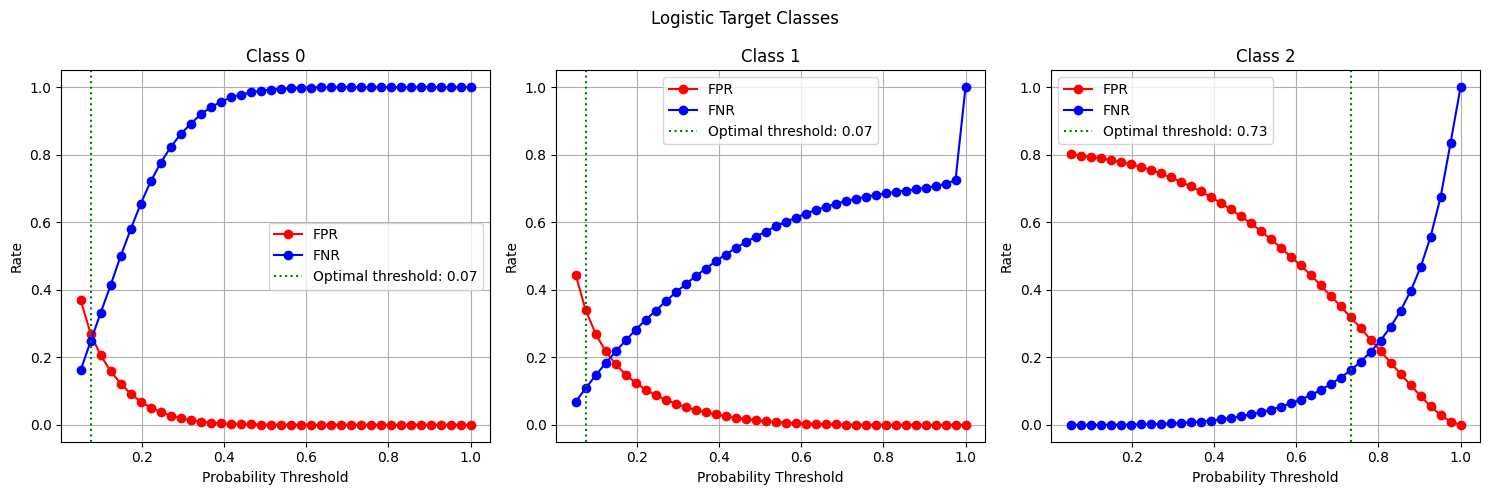

In [39]:
num_classes = 3
thresholds = np.linspace(0.05, 1, 40)
num_thresholds = len(thresholds)


# Dictionaries to collect validation metrics for each class, for each fold.
valid_fnrs_folds = {i: [] for i in range(num_classes)}
valid_fnps_folds = {i: [] for i in range(num_classes)}

# Iterate over Stratified K-Fold cross-validation
for train_idx, valid_idx in skf.split(x_train, y_train_bin):
    X_train_fold = x_train.iloc[train_idx]
    X_valid_fold = x_train.iloc[valid_idx]
    y_train_fold = y_train_bin.iloc[train_idx]
    y_valid_fold = y_train_bin.iloc[valid_idx]
    
    # Fit the model on the training fold
    model.fit(X_train_fold, y_train_fold)
    
    # Get predicted probabilities for the validation fold once per fold
    valid_probs = model.predict_proba(X_valid_fold)  # shape: (n_samples, num_classes)
    
    # Temporary dictionaries to store metrics for each class in this fold.
    valid_fnrs_temp = {i: [] for i in range(num_classes)}
    valid_fnps_temp = {i: [] for i in range(num_classes)}
    
    # Loop over thresholds
    for threshold in thresholds:
        for i in range(num_classes):
            # Create a one-vs-all binary label: 1 if sample belongs to class i, else 0.
            y_valid_true_i = (y_valid_fold == i).astype(int)
            # For the prediction, threshold the probability for class i.
            y_valid_pred_i = (valid_probs[:, i] >= threshold).astype(int)
            
            # Compute confusion matrix for binary classification.
            cm = confusion_matrix(y_valid_true_i, y_valid_pred_i, labels=[0, 1])
            tn, fp, fn, tp = cm.ravel()
            
            # Calculate FNR and FPR safely (handle division by zero)
            FNR = fn / (fn + tp) if (fn + tp) > 0 else 0
            FPR = fp / (fp + tn) if (fp + tn) > 0 else 0
            
            valid_fnrs_temp[i].append(FNR)
            valid_fnps_temp[i].append(FPR)
    
    # Append results from this fold for each class
    for i in range(num_classes):
        valid_fnrs_folds[i].append(valid_fnrs_temp[i])
        valid_fnps_folds[i].append(valid_fnps_temp[i])

# Now average the metrics across folds for each threshold, for each class.
valid_fnrs_by_class = {}
valid_fnps_by_class = {}

for i in range(num_classes):
    valid_fnrs_by_class[i] = np.mean(np.array(valid_fnrs_folds[i]), axis=0)
    valid_fnps_by_class[i] = np.mean(np.array(valid_fnps_folds[i]), axis=0)

# Define an acceptable max FPR threshold
MAX_FPR_THRESHOLD = 0.35  # Adjust this to your tolerance level for false positives

optimal_thresholds = []

plt.figure(figsize=(15, 5))

for i in range(num_classes):
    plt.subplot(1, num_classes, i+1)
    
    # Plot FPR and FNR vs thresholds for each class
    plt.plot(thresholds, valid_fnps_by_class[i], marker='o', color='red', label='FPR')
    plt.plot(thresholds, valid_fnrs_by_class[i], marker='o', color='blue', label='FNR')
    
    # Determine the optimal threshold (prioritizing low FNR while controlling FPR)
    fnrs = np.array(valid_fnrs_by_class[i])
    fprs = np.array(valid_fnps_by_class[i])

    # Find indices where FPR is within the acceptable range
    valid_indices = np.where(fprs <= MAX_FPR_THRESHOLD)[0]

    if len(valid_indices) > 0:
        # Select the threshold with the lowest FNR within the valid FPR range
        idx_min_fn = valid_indices[np.argmin(fnrs[valid_indices])]
    else:
        # If no threshold meets the FPR constraint, just minimize FNR
        idx_min_fn = np.argmin(fnrs)
    
    opt_threshold = thresholds[idx_min_fn]
    optimal_thresholds.append(opt_threshold)
    
    # Mark the optimal threshold with a vertical line
    plt.axvline(opt_threshold, color='green', linestyle=':', 
                label=f'Optimal threshold: {opt_threshold:.2f}')
    
    plt.xlabel('Probability Threshold')
    plt.ylabel('Rate')
    plt.title(f'Class {i}')
    plt.legend()
    plt.grid(True)

plt.suptitle("Logistic Target Classes")
plt.tight_layout()
plt.show()

In [40]:
def predict_with_thresholds(probs, thresholds):
    """
    Custom prediction function that uses one-vs-all thresholds.
    
    Parameters:
      probs: np.array of shape (n_samples, num_classes) with predicted probabilities.
      thresholds: dict mapping class index to threshold value.
      
    Returns:
      predictions: np.array of predicted class labels.
    """
    predictions = []
    
    for sample in probs:
        # List of candidate classes for which the probability exceeds the threshold.
        candidate_classes = [i for i in range(len(sample)) if sample[i] >= thresholds[i]]
        if len(candidate_classes) == 1:
            pred = candidate_classes[0]
        elif len(candidate_classes) > 1:
            # If more than one class exceeds its threshold, choose the one with the highest probability.
            pred = max(candidate_classes, key=lambda i: sample[i])
        else:
            # If no class exceeds its threshold, fall back to the class with highest probability.
            pred = np.argmax(sample)
        predictions.append(pred)
    return np.array(predictions)

Logistic Classification

In [41]:
# Split the training dataset into 80% training and 20% validation sets
x_train_sub, x_val, y_train_sub, y_val = train_test_split(x_train, y_train_bin, test_size=0.2, random_state=42, stratify=y_train_bin)

# Check the shapes of the new datasets
print("X_train_sub shape:", x_train_sub.shape)
print("X_val shape:", x_val.shape)
print("y_train_sub shape:", y_train_sub.shape)
print("y_val shape:", y_val.shape)




###################################################################################################################3
# Train your final model on the training sub set
model.fit(x_train_sub, y_train_sub)

# Predict probabilities on the test set
val_probs = model.predict_proba(x_val)


# Get predictions using the custom thresholding rule
y_pred = predict_with_thresholds(val_probs, optimal_thresholds)

# Compute metrics
acc = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred)
f1 = f1_score(y_val, y_pred, average='weighted')


print("LOGISTIC REGRESSION RESULTS")
print("Validation results")
print("Accuracy:", acc)
print("Classification Report:\n", report)
print("Weighted F1 Score:", f1)



##########################################################################################
# Train your final model on the entire training set
model.fit(x_train, y_train_bin)

# Predict probabilities on the test set
test_probs = model.predict_proba(x_test)


# Get predictions using the custom thresholding rule
y_pred = predict_with_thresholds(test_probs, optimal_thresholds)

# Compute metrics
acc = accuracy_score(y_test_bin, y_pred)
report = classification_report(y_test_bin, y_pred)
f1 = f1_score(y_test_bin, y_pred, average='weighted')


print("Test results")
print("Accuracy:", acc)
print("Classification Report:\n", report)
print("Weighted F1 Score:", f1)

X_train_sub shape: (276191, 318)
X_val shape: (69048, 318)
y_train_sub shape: (276191,)
y_val shape: (69048,)


C:\Users\liuya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LOGISTIC REGRESSION RESULTS
Validation results
Accuracy: 0.7805294867338664
Classification Report:
               precision    recall  f1-score   support

           0       0.27      0.29      0.28      4730
           1       0.51      0.69      0.59     10068
           2       0.91      0.84      0.87     54250

    accuracy                           0.78     69048
   macro avg       0.56      0.61      0.58     69048
weighted avg       0.80      0.78      0.79     69048

Weighted F1 Score: 0.7894358708559521


C:\Users\liuya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Test results
Accuracy: 0.7803614876607577
Classification Report:
               precision    recall  f1-score   support

           0       0.27      0.29      0.28      5888
           1       0.50      0.68      0.58     12424
           2       0.91      0.84      0.87     67998

    accuracy                           0.78     86310
   macro avg       0.56      0.61      0.58     86310
weighted avg       0.80      0.78      0.79     86310

Weighted F1 Score: 0.7895625341444844


Threshold Determination For XGBoost Classification

C:\Users\liuya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\core.py:158: UserWarning: [10:41:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\liuya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\core.py:158: UserWarning: [10:42:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\liuya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\core.py:158: UserWarnin

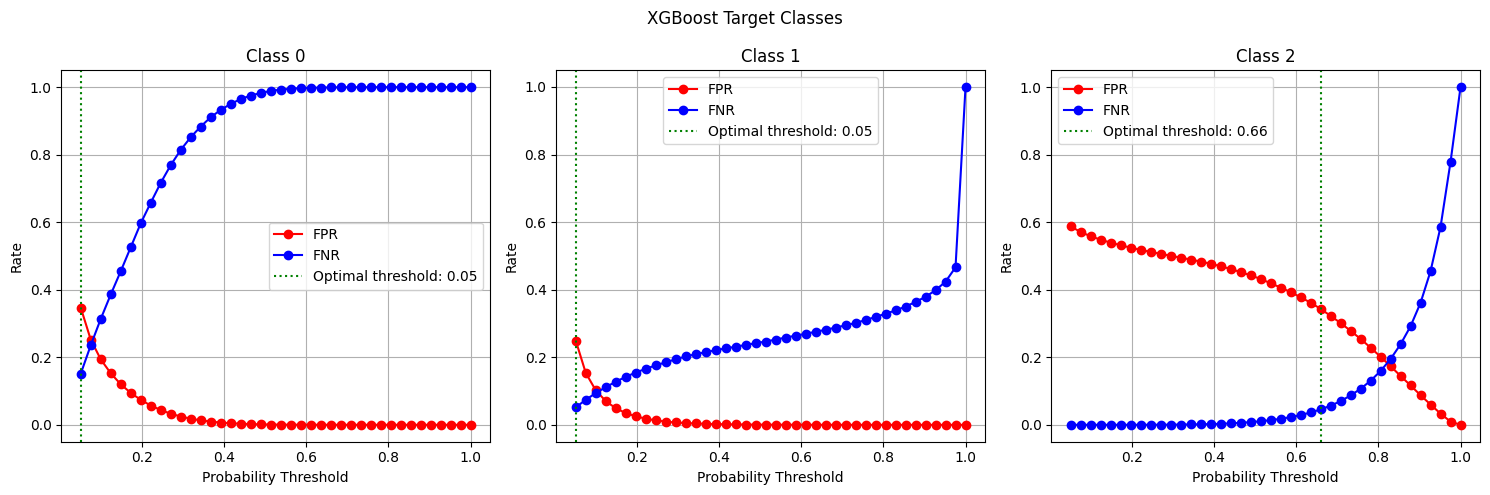

In [44]:
# Dictionaries to collect validation metrics for each class, for each fold.
valid_fnrs_folds = {i: [] for i in range(num_classes)}
valid_fnps_folds = {i: [] for i in range(num_classes)}

# Iterate over Stratified K-Fold cross-validation
for train_idx, valid_idx in skf.split(x_train, y_train_bin):
    X_train_fold = x_train.iloc[train_idx]
    X_valid_fold = x_train.iloc[valid_idx]
    y_train_fold = y_train_bin.iloc[train_idx]
    y_valid_fold = y_train_bin.iloc[valid_idx]
    
    # Fit the model on the training fold
    model_xg_boost.fit(X_train_fold, y_train_fold)
    
    # Get predicted probabilities for the validation fold once per fold
    valid_probs = model_xg_boost.predict_proba(X_valid_fold)  # shape: (n_samples, num_classes)
    
    # Temporary dictionaries to store metrics for each class in this fold.
    valid_fnrs_temp = {i: [] for i in range(num_classes)}
    valid_fnps_temp = {i: [] for i in range(num_classes)}
    
    # Loop over thresholds
    for threshold in thresholds:
        for i in range(num_classes):
            # Create a one-vs-all binary label: 1 if sample belongs to class i, else 0.
            y_valid_true_i = (y_valid_fold == i).astype(int)
            # For the prediction, threshold the probability for class i.
            y_valid_pred_i = (valid_probs[:, i] >= threshold).astype(int)
            
            # Compute confusion matrix for binary classification.
            cm = confusion_matrix(y_valid_true_i, y_valid_pred_i, labels=[0, 1])
            tn, fp, fn, tp = cm.ravel()
            
            # Calculate FNR and FPR safely (handle division by zero)
            FNR = fn / (fn + tp) if (fn + tp) > 0 else 0
            FPR = fp / (fp + tn) if (fp + tn) > 0 else 0
            
            valid_fnrs_temp[i].append(FNR)
            valid_fnps_temp[i].append(FPR)
    
    # Append results from this fold for each class
    for i in range(num_classes):
        valid_fnrs_folds[i].append(valid_fnrs_temp[i])
        valid_fnps_folds[i].append(valid_fnps_temp[i])

# Now average the metrics across folds for each threshold, for each class.
valid_fnrs_by_class = {}
valid_fnps_by_class = {}

for i in range(num_classes):
    valid_fnrs_by_class[i] = np.mean(np.array(valid_fnrs_folds[i]), axis=0)
    valid_fnps_by_class[i] = np.mean(np.array(valid_fnps_folds[i]), axis=0)

# Define an acceptable max FPR threshold
MAX_FPR_THRESHOLD = 0.35  # Adjust this to your tolerance level for false positives

optimal_thresholds = []

plt.figure(figsize=(15, 5))

for i in range(num_classes):
    plt.subplot(1, num_classes, i+1)
    
    # Plot FPR and FNR vs thresholds for each class
    plt.plot(thresholds, valid_fnps_by_class[i], marker='o', color='red', label='FPR')
    plt.plot(thresholds, valid_fnrs_by_class[i], marker='o', color='blue', label='FNR')
    
    # Determine the optimal threshold (prioritizing low FNR while controlling FPR)
    fnrs = np.array(valid_fnrs_by_class[i])
    fprs = np.array(valid_fnps_by_class[i])

    # Find indices where FPR is within the acceptable range
    valid_indices = np.where(fprs <= MAX_FPR_THRESHOLD)[0]

    if len(valid_indices) > 0:
        # Select the threshold with the lowest FNR within the valid FPR range
        idx_min_fn = valid_indices[np.argmin(fnrs[valid_indices])]
    else:
        # If no threshold meets the FPR constraint, just minimize FNR
        idx_min_fn = np.argmin(fnrs)
    
    opt_threshold = thresholds[idx_min_fn]
    optimal_thresholds.append(opt_threshold)
    
    # Mark the optimal threshold with a vertical line
    plt.axvline(opt_threshold, color='green', linestyle=':', 
                label=f'Optimal threshold: {opt_threshold:.2f}')
    
    plt.xlabel('Probability Threshold')
    plt.ylabel('Rate')
    plt.title(f'Class {i}')
    plt.legend()
    plt.grid(True)

plt.suptitle("XGBoost Target Classes")
plt.tight_layout()
plt.show()

XGBoost Classification

In [45]:
###################################################################################################################3
# Train your final model on the training sub set
model_xg_boost.fit(x_train_sub, y_train_sub)

# Predict probabilities on the test set
val_probs = model_xg_boost.predict_proba(x_val)


# Get predictions using the custom thresholding rule
y_pred = predict_with_thresholds(val_probs, optimal_thresholds)


print("XGBOOST RESULTS")
print("Validation results")
# Compute metrics
acc = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred)
f1 = f1_score(y_val, y_pred, average='weighted')

print("Accuracy:", acc)
print("Classification Report:\n", report)
print("Weighted F1 Score:", f1)



##########################################################################################
# Train your final model on the entire training set
model_xg_boost.fit(x_train, y_train_bin)

# Predict probabilities on the test set
test_probs = model_xg_boost.predict_proba(x_test)


# Get predictions using the custom thresholding rule
y_pred = predict_with_thresholds(test_probs, optimal_thresholds)


print("Test results")
# Compute metrics
acc = accuracy_score(y_test_bin, y_pred)
report = classification_report(y_test_bin, y_pred)
f1 = f1_score(y_test_bin, y_pred, average='weighted')

print("Accuracy:", acc)
print("Classification Report:\n", report)
print("Weighted F1 Score:", f1)
print(confusion_matrix(y_test_bin, y_pred))

C:\Users\liuya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\core.py:158: UserWarning: [10:44:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBOOST RESULTS
Validation results
Accuracy: 0.8879185494148998
Classification Report:
               precision    recall  f1-score   support

           0       0.34      0.23      0.28      4730
           1       0.93      0.83      0.88     10068
           2       0.91      0.96      0.93     54250

    accuracy                           0.89     69048
   macro avg       0.73      0.67      0.70     69048
weighted avg       0.88      0.89      0.88     69048

Weighted F1 Score: 0.8803938230107521


C:\Users\liuya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\core.py:158: UserWarning: [10:45:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Test results
Accuracy: 0.8853203568532035
Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.23      0.27      5888
           1       0.93      0.81      0.86     12424
           2       0.91      0.96      0.93     67998

    accuracy                           0.89     86310
   macro avg       0.72      0.67      0.69     86310
weighted avg       0.87      0.89      0.88     86310

Weighted F1 Score: 0.8778498313357814
[[ 1368   149  4371]
 [  343 10083  1998]
 [ 2375   662 64961]]


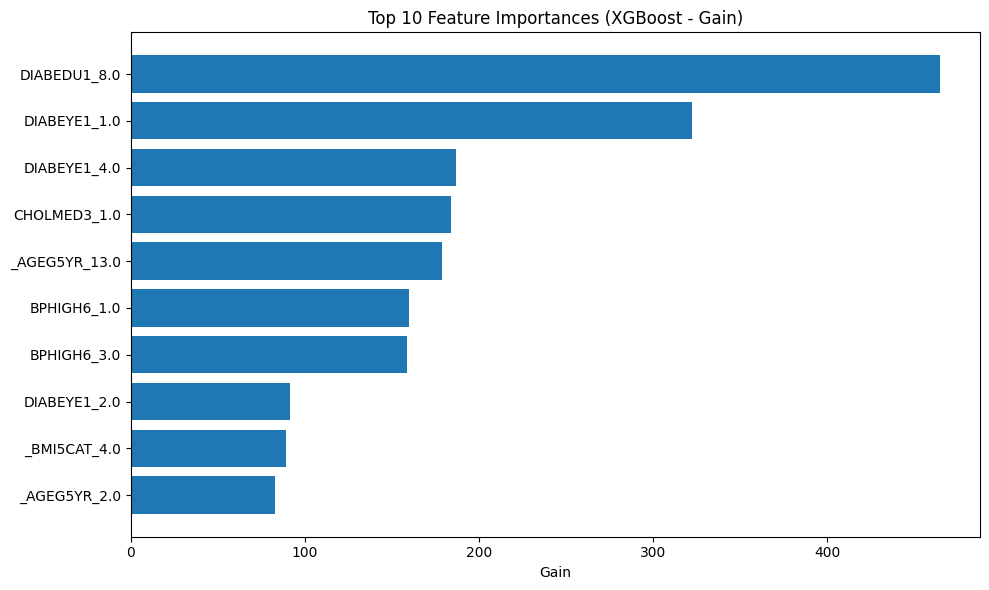

In [46]:
import pandas as pd
import matplotlib.pyplot as plt

# Get feature importance based on 'gain' from the XGBoost model
importance_dict = model_xg_boost.get_booster().get_score(importance_type='gain')
importance_df = pd.DataFrame({
    'Feature': list(importance_dict.keys()),
    'Importance': list(importance_dict.values())
}).sort_values(by='Importance', ascending=False)

# Select top 10 most important features
top_n = 10
top_features = importance_df.head(top_n)

# Plot the top N features as a horizontal bar chart
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'][::-1], top_features['Importance'][::-1])  # Reverse to show most important on top
plt.xlabel("Gain")
plt.title(f"Top {top_n} Feature Importances (XGBoost - Gain)")
plt.tight_layout()
plt.show()

Determing Optimal Thresholds For Random Forest Classification

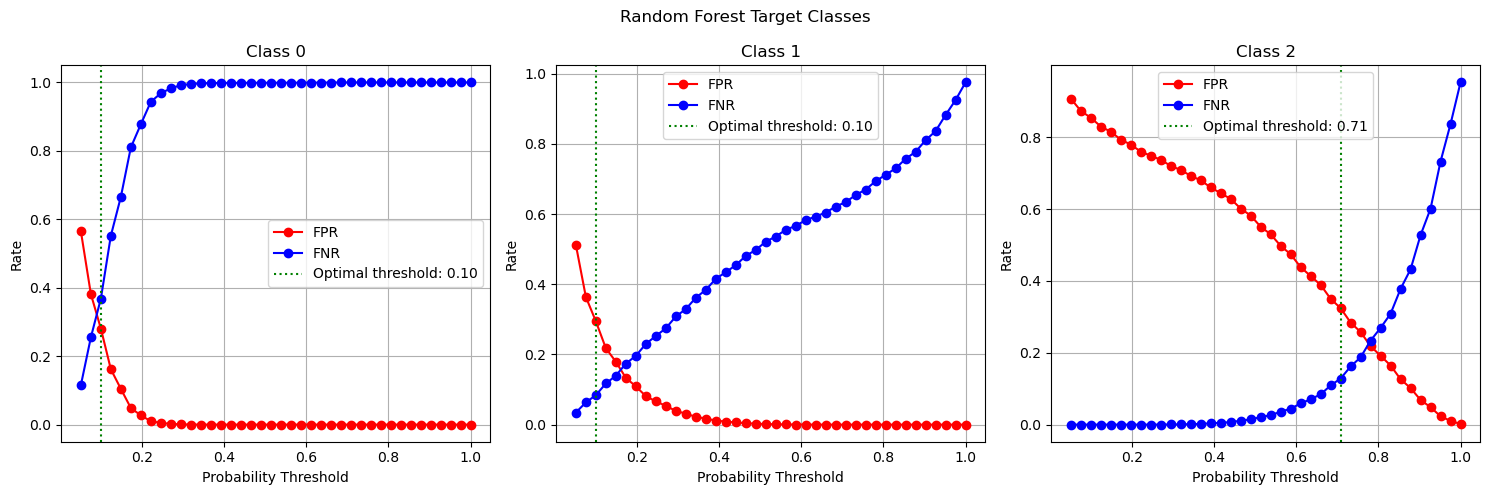

In [372]:
# Dictionaries to collect validation metrics for each class, for each fold.
valid_fnrs_folds = {i: [] for i in range(num_classes)}
valid_fnps_folds = {i: [] for i in range(num_classes)}

# Iterate over Stratified K-Fold cross-validation
for train_idx, valid_idx in skf.split(x_train, y_train_bin):
    X_train_fold = x_train.iloc[train_idx]
    X_valid_fold = x_train.iloc[valid_idx]
    y_train_fold = y_train_bin.iloc[train_idx]
    y_valid_fold = y_train_bin.iloc[valid_idx]
    
    # Fit the model on the training fold
    model_rf.fit(X_train_fold, y_train_fold)
    
    # Get predicted probabilities for the validation fold once per fold
    valid_probs = model_rf.predict_proba(X_valid_fold)  # shape: (n_samples, num_classes)
    
    # Temporary dictionaries to store metrics for each class in this fold.
    valid_fnrs_temp = {i: [] for i in range(num_classes)}
    valid_fnps_temp = {i: [] for i in range(num_classes)}
    
    # Loop over thresholds
    for threshold in thresholds:
        for i in range(num_classes):
            # Create a one-vs-all binary label: 1 if sample belongs to class i, else 0.
            y_valid_true_i = (y_valid_fold == i).astype(int)
            # For the prediction, threshold the probability for class i.
            y_valid_pred_i = (valid_probs[:, i] >= threshold).astype(int)
            
            # Compute confusion matrix for binary classification.
            cm = confusion_matrix(y_valid_true_i, y_valid_pred_i, labels=[0, 1])
            tn, fp, fn, tp = cm.ravel()
            
            # Calculate FNR and FPR safely (handle division by zero)
            FNR = fn / (fn + tp) if (fn + tp) > 0 else 0
            FPR = fp / (fp + tn) if (fp + tn) > 0 else 0
            
            valid_fnrs_temp[i].append(FNR)
            valid_fnps_temp[i].append(FPR)
    
    # Append results from this fold for each class
    for i in range(num_classes):
        valid_fnrs_folds[i].append(valid_fnrs_temp[i])
        valid_fnps_folds[i].append(valid_fnps_temp[i])

# Now average the metrics across folds for each threshold, for each class.
valid_fnrs_by_class = {}
valid_fnps_by_class = {}

for i in range(num_classes):
    valid_fnrs_by_class[i] = np.mean(np.array(valid_fnrs_folds[i]), axis=0)
    valid_fnps_by_class[i] = np.mean(np.array(valid_fnps_folds[i]), axis=0)

# Define an acceptable max FPR threshold
MAX_FPR_THRESHOLD = 0.35  # Adjust this to your tolerance level for false positives

optimal_thresholds = []

plt.figure(figsize=(15, 5))

for i in range(num_classes):
    plt.subplot(1, num_classes, i+1)
    
    # Plot FPR and FNR vs thresholds for each class
    plt.plot(thresholds, valid_fnps_by_class[i], marker='o', color='red', label='FPR')
    plt.plot(thresholds, valid_fnrs_by_class[i], marker='o', color='blue', label='FNR')
    
    # Determine the optimal threshold (prioritizing low FNR while controlling FPR)
    fnrs = np.array(valid_fnrs_by_class[i])
    fprs = np.array(valid_fnps_by_class[i])

    # Find indices where FPR is within the acceptable range
    valid_indices = np.where(fprs <= MAX_FPR_THRESHOLD)[0]

    if len(valid_indices) > 0:
        # Select the threshold with the lowest FNR within the valid FPR range
        idx_min_fn = valid_indices[np.argmin(fnrs[valid_indices])]
    else:
        # If no threshold meets the FPR constraint, just minimize FNR
        idx_min_fn = np.argmin(fnrs)
    
    opt_threshold = thresholds[idx_min_fn]
    optimal_thresholds.append(opt_threshold)
    
    # Mark the optimal threshold with a vertical line
    plt.axvline(opt_threshold, color='green', linestyle=':', 
                label=f'Optimal threshold: {opt_threshold:.2f}')
    
    plt.xlabel('Probability Threshold')
    plt.ylabel('Rate')
    plt.title(f'Class {i}')
    plt.legend()
    plt.grid(True)

plt.suptitle("Random Forest Target Classes")
plt.tight_layout()
plt.show()

Random Forest Classification

In [373]:
###################################################################################################################3
# Train your final model on the training sub set
model_rf.fit(x_train_sub, y_train_sub)

# Predict probabilities on the test set
val_probs = model_rf.predict_proba(x_val)


# Get predictions using the custom thresholding rule
y_pred = predict_with_thresholds(val_probs, optimal_thresholds)

# Compute metrics
acc = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred)
f1 = f1_score(y_val, y_pred, average='weighted')


print("RANDOM FOREST RESULTS")
print("Validation results")
print("Accuracy:", acc)
print("Classification Report:\n", report)
print("Weighted F1 Score:", f1)



##########################################################################################
# Train your final model on the entire training set
model_rf.fit(x_train, y_train_bin)

# Predict probabilities on the test set
test_probs = model_rf.predict_proba(x_test)


# Get predictions using the custom thresholding rule
y_pred = predict_with_thresholds(test_probs, optimal_thresholds)

# Compute metrics
acc = accuracy_score(y_test_bin, y_pred)
report = classification_report(y_test_bin, y_pred)
f1 = f1_score(y_test_bin, y_pred, average='weighted')

print("Test results")
print("Accuracy:", acc)
print("Classification Report:\n", report)
print("Weighted F1 Score:", f1)

RANDOM FOREST RESULTS
Validation results
Accuracy: 0.8078583014714401
Classification Report:
               precision    recall  f1-score   support

           0       0.23      0.10      0.14      4730
           1       0.54      0.80      0.65     10068
           2       0.91      0.87      0.89     54250

    accuracy                           0.81     69048
   macro avg       0.56      0.59      0.56     69048
weighted avg       0.81      0.81      0.80     69048

Weighted F1 Score: 0.8023874866107515
Test results
Accuracy: 0.8073108562159657
Classification Report:
               precision    recall  f1-score   support

           0       0.24      0.12      0.16      5888
           1       0.54      0.79      0.64     12424
           2       0.91      0.87      0.89     67998

    accuracy                           0.81     86310
   macro avg       0.56      0.59      0.56     86310
weighted avg       0.81      0.81      0.80     86310

Weighted F1 Score: 0.8030793898889215


In [47]:
comorbidities_cdc2023.sample(6)

,_STATE,SEXVAR,GENHLTH,PHYSHLTH,MENTHLTH,POORHLTH,PRIMINS1,MEDCOST1,CHECKUP1,EXERANY2,EXRACT12,EXEROFT1,BPHIGH6,BPMEDS1,CHOLCHK3,TOLDHI3,CHOLMED3,CVDINFR4,CVDCRHD4,CVDSTRK3,ASTHMA3,ASTHNOW,CHCSCNC1,CHCOCNC1,CHCCOPD3,ADDEPEV3,CHCKDNY2,HAVARTH4,DIABETE4,DIABAGE4,MARITAL,EDUCA,VETERAN3,EMPLOY1,CHILDREN,INCOME3,PREGNANT,DEAF,BLIND,DECIDE,DIFFWALK,DIFFDRES,DIFFALON,FALLINJ5,USENOW3,ECIGNOW2,FLUSHOT7,PNEUVAC4,SHINGLE2,HIVTST7,SEATBELT,COVIDPO1,COVIDSM1,PREDIAB2,INSULIN1,CHKHEMO3,DIABEYE1,DIABEDU1,FEETSORE,ARTHDIS2,LCSCTSC1,CAREGIV1,HEATTBCO,ASPIRIN,ACEDIVRC,COVIDVA1,COVIDNU2,EMTSUPRT,SDLONELY,SDHEMPLY,FOODSTMP,SDHFOOD1,SDHSTRE1,_URBSTAT,_IMPRACE,MAXVO21_,ACTIN13_,ACTIN23_,PADUR1_,STRFREQ_,_PACAT3,_PA300R4,_PAREC3,_RFHYPE6,_LTASTH1,_MRACE1,_AGEG5YR,HTM4,WTKG3,_BMI5CAT,_SMOKER3,_CURECI2,DRNKANY6,_RFDRHV8,_DRNKDRV
417040,55.000000,2.000000,2.000000,0.000000,15.000000,7.000000,1.000000,2.000000,2.000000,1.000000,1.000000,0.000000,3.000000,1.000000,3.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,1.000000,2.000000,1.000000,3.000000,36.500000,1.000000,6.000000,2.000000,1.000000,2.000000,9.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.000000,3.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,2.000000,3.000000,2.000000,3.000000,2.000000,8.000000,2.000000,2.000000,2.000000,2.000000,2.000000,4.000000,2.000000,1.000000,2.000000,3.000000,3.000000,2.000000,2.000000,5.000000,2.000000,1.000000,3.000000,31.720000,1.000000,1.000000,30.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.000000,4.000000,5.000000,1.650000,63.500000,2.000000,3.000000,1.000000,1.000000,1.000000,2.000000
324552,45.000000,1.000000,4.000000,10.000000,10.000000,0.000000,1.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,3.000000,46.000000,5.000000,4.000000,2.000000,1.000000,2.000000,9.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.000000,3.000000,1.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,2.000000,3.000000,2.000000,2.000000,2.000000,8.000000,2.000000,2.000000,1.000000,2.000000,2.000000,4.000000,2.000000,1.000000,3.000000,1.000000,5.000000,2.000000,2.000000,5.000000,5.000000,1.000000,1.000000,28.100000,1.000000,1.000000,60.000000,0.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,8.000000,1.930000,158.760000,4.000000,4.000000,1.000000,1.000000,1.000000,2.000000
365311,50.000000,1.000000,3.000000,0.000000,29.000000,25.000000,10.000000,2.000000,3.000000,2.000000,1.000000,3.000000,1.000000,2.000000,5.000000,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,1.000000,2.000000,2.000000,2.000000,1.000000,2.000000,1.000000,3.000000,51.000000,6.000000,6.000000,2.000000,1.000000,2.000000,7.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.000000,3.000000,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,3.000000,2.000000,2.000000,2.000000,8.000000,2.000000,2.000000,1.000000,2.000000,2.000000,4.000000,2.000000,1.000000,4.000000,1.000000,5.000000,2.000000,2.000000,5.000000,5.000000,1.000000,1.000000,26.450000,1.000000,1.000000,60.000000,0.000000,4.000000,3.000000,4.000000,2.000000,1.000000,1.000000,9.000000,1.750000,74.840000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000
130005,20.000000,2.000000,1.000000,0.000000,5.000000,0.000000,1.000000,2.000000,1.000000,1.000000,1.000000,7.000000,3.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,3.000000,50.000000,1.000000,6.000000,2.000000,2.000000,2.000000,11.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.000000,3.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,2.000000,2.000000,3.000000,2.000000,2.000000,2.000000,8.000000,2.000000,2.000000,2.000000,2.000000,2.00000

In [48]:
cat_to_col.remove('CVDSTRK3')
cat_to_col.append('PREDIAB2')
cat_to_col.append('DIABETE4')

comorbidities_cdc2023 = pd.get_dummies(comorbidities_cdc2023, columns=cat_to_col, drop_first=False, dtype=int)


# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the scaler on the numerical columns of the training set and transform them
comorbidities_cdc2023[num_to_col] = scaler.fit_transform(comorbidities_cdc2023[num_to_col])

# Check the results
print("Scaled Data:")
comorbidities_cdc2023.sample(5)

Scaled Data:


,PHYSHLTH,MENTHLTH,POORHLTH,EXEROFT1,CVDSTRK3,DIABAGE4,EDUCA,CHILDREN,INCOME3,FALLINJ5,CHKHEMO3,COVIDNU2,MAXVO21_,ACTIN13_,ACTIN23_,PADUR1_,STRFREQ_,HTM4,WTKG3,ADDEPEV3_1.0,ADDEPEV3_2.0,ASTHMA3_1.0,ASTHMA3_2.0,BLIND_1.0,BLIND_2.0,BPHIGH6_1.0,BPHIGH6_2.0,BPHIGH6_3.0,BPHIGH6_4.0,BPMEDS1_1.0,BPMEDS1_2.0,CHCCOPD3_1.0,CHCCOPD3_2.0,CHCKDNY2_1.0,CHCKDNY2_2.0,CHCOCNC1_1.0,CHCOCNC1_2.0,CHCSCNC1_1.0,CHCSCNC1_2.0,CHECKUP1_1.0,CHECKUP1_2.0,CHECKUP1_3.0,CHECKUP1_4.0,CHECKUP1_8.0,CHOLCHK3_1.0,CHOLCHK3_2.0,CHOLCHK3_3.0,CHOLCHK3_4.0,CHOLCHK3_5.0,CHOLCHK3_6.0,CHOLCHK3_8.0,CHOLMED3_1.0,CHOLMED3_2.0,COVIDPO1_1.0,COVIDPO1_2.0,COVIDSM1_1.0,COVIDSM1_2.0,COVIDVA1_1.0,COVIDVA1_2.0,CVDCRHD4_1.0,CVDCRHD4_2.0,CVDINFR4_1.0,CVDINFR4_2.0,DEAF_1.0,DEAF_2.0,DECIDE_1.0,DECIDE_2.0,DIFFALON_1.0,DIFFALON_2.0,DIFFDRES_1.0,DIFFDRES_2.0,DIFFWALK_1.0,DIFFWALK_2.0,ECIGNOW2_1.0,ECIGNOW2_2.0,ECIGNOW2_3.0,ECIGNOW2_4.0,EMPLOY1_1.0,EMPLOY1_2.0,EMPLOY1_3.0,EMPLOY1_4.0,EMPLOY1_5.0,EMPLOY1_6.0,EMPLOY1_7.0,EMPLOY1_8.0,EMTSUPRT_1.0,EMTSUPRT_2.0,EMTSUPRT_3.0,EMTSUPRT_4.0,EMTSUPRT_5.0,EXERANY2_1.0,EXERANY2_2.0,EXRACT12_1.0,EXRACT12_2.0,EXRACT12_3.0,EXRACT12_4.0,EXRACT12_5.0,EXRACT12_6.0,EXRACT12_7.0,EXRACT12_8.0,EXRACT12_9.0,EXRACT12_10.0,EXRACT12_11.0,FLUSHOT7_1.0,FLUSHOT7_2.0,FOODSTMP_1.0,FOODSTMP_2.0,GENHLTH_1.0,GENHLTH_2.0,GENHLTH_3.0,GENHLTH_4.0,GENHLTH_5.0,HAVARTH4_1.0,HAVARTH4_2.0,HEATTBCO_1.0,HEATTBCO_2.0,HIVTST7_1.0,HIVTST7_2.0,MARITAL_1.0,MARITAL_2.0,MARITAL_3.0,MARITAL_4.0,MARITAL_5.0,MARITAL_6.0,MEDCOST1_1.0,MEDCOST1_2.0,PNEUVAC4_1.0,PNEUVAC4_2.0,PRIMINS1_1.0,PRIMINS1_2.0,PRIMINS1_3.0,PRIMINS1_4.0,PRIMINS1_5.0,PRIMINS1_6.0,PRIMINS1_7.0,PRIMINS1_8.0,PRIMINS1_9.0,PRIMINS1_10.0,PRIMINS1_88.0,SDHEMPLY_1.0,SDHEMPLY_2.0,SDHFOOD1_1.0,SDHFOOD1_2.0,SDHFOOD1_3.0,SDHFOOD1_4.0,SDHFOOD1_5.0,SDHSTRE1_1.0,SDHSTRE1_2.0,SDHSTRE1_3.0,SDHSTRE1_4.0,SDHSTRE1_5.0,SDLONELY_1.0,SDLONELY_2.0,SDLONELY_3.0,SDLONELY_4.0,SDLONELY_5.0,SEATBELT_1.0,SEATBELT_2.0,SEATBELT_3.0,SEATBELT_4.0,SEATBELT_5.0,SEATBELT_8.0,SHINGLE2_1.0,SHINGLE2_2.0,TOLDHI3_1.0,TOLDHI3_2.0,USENOW3_1.0,USENOW3_2.0,USENOW3_3.0,VETERAN3_1.0,VETERAN3_2.0,_BMI5CAT_1.0,_BMI5CAT_2.0,_BMI5CAT_3.0,_BMI5CAT_4.0,_MRACE1_1.0,_MRACE1_2.0,_MRACE1_3.0,_MRACE1_4.0,_MRACE1_5.0,_MRACE1_6.0,_MRACE1_7.0,_URBSTAT_1.0,_URBSTAT_2.0,_STATE_1.0,_STATE_2.0,_STATE_4.0,_STATE_5.0,_STATE_6.0,_STATE_8.0,_STATE_10.0,_STATE_11.0,_STATE_12.0,_STATE_13.0,_STATE_15.0,_STATE_16.0,_STATE_17.0,_STATE_18.0,_STATE_19.0,_STATE_20.0,_STATE_22.0,_STATE_23.0,_STATE_24.0,_STATE_25.0,_STATE_26.0,_STATE_27.0,_STATE_28.0,_STATE_29.0,_STATE_30.0,_STATE_31.0,_STATE_32.0,_STATE_33.0,_STATE_34.0,_STATE_35.0,_STATE_36.0,_STATE_37.0,_STATE_38.0,_STATE_39.0,_STATE_40.0,_STATE_41.0,_STATE_44.0,_STATE_45.0,_STATE_46.0,_STATE_47.0,_STATE_48.0,_STATE_49.0,_STATE_50.0,_STATE_51.0,_STATE_53.0,_STATE_54.0,_STATE_55.0,_STATE_56.0,_STATE_66.0,_STATE_72.0,_STATE_78.0,SEXVAR_1.0,SEXVAR_2.0,_IMPRACE_1.0,_IMPRACE_2.0,_IMPRACE_3.0,_IMPRACE_4.0,_IMPRACE_5.0,_IMPRACE_6.0,_PACAT3_1.0,_PACAT3_2.0,_PACAT3_3.0,_PACAT3_4.0,_PA300R4_1.0,_PA300R4_2.0,_PA300R4_3.0,_PAREC3_1.0,_PAREC3_2.0,_PAREC3_3.0,_PAREC3_4.0,_RFHYPE6_1.0,_RFHYPE6_2.0,_LTASTH1_1.0,_LTASTH1_2.0,_AGEG5YR_1.0,_AGEG5YR_2.0,_AGEG5YR_3.0,_AGEG5YR_4.0,_AGEG5YR_5.0,_AGEG5YR_6.0,_AGEG5YR_7.0,_AGEG5YR_8.0,_AGEG5YR_9.0,_AGEG5YR_10.0,_AGEG5YR_11.0,_AGEG5YR_12.0,_AGEG5YR_13.0,_SMOKER3_1.0,_SMOKER3_2.0,_SMOKER3_3.0,_SMOKER3_4.0,_CURECI2_1.0,_CURECI2_2.0,DRNKANY6_1.0,DRNKANY6_2.0,_RFDRHV8_1.0,_RFDRHV8_2.0,_DRNKDRV_1.0,_DRNKDRV_2.0,PREGNANT_1.0,PREGNANT_2.0,ASTHNOW_1.0,ASTHNOW_2.0,ACEDIVRC_1.0,ACEDIVRC_2.0,ACEDIVRC_8.0,CAREGIV1_1.0,CAREGIV1_2.0,CAREGIV1_8.0,ASPIRIN_1.0,ASPIRIN_2.0,ASPIRIN_3.0,ASPIRIN_4.0,ARTHDIS2_1.0,ARTHDIS2_2.0,LCSCTSC1_1.0,LCSCTSC1_2.0,FEETSORE_1.0,FEETSORE_2.0,DIABEDU1_1.0,DIABEDU1_2.0,DIABEDU1_3.0,DIABEDU1_4.0,DIABEDU1_5.0,DIABEDU1_6.0,DIABEDU1_8.0,DIABEYE1_1.0,DIABEYE1_2.0,DIABEYE1_3.0,DIABEYE1_4.0,DIABEYE1_8.0,INSULIN1_1.0,INSULIN1_2.0,PREDIAB2_1.0,PREDIAB2_2.0,PREDIAB2_3.0,PREDIAB2_7.0,PREDIAB2_9.0,DIABETE4_1.0,DIABETE4_2.0,D

In [49]:
# Split the dataset into 80% training and 20% testing sets
train, test = train_test_split(comorbidities_cdc2023, test_size=0.20, random_state=42)

# Check the shapes of the splits
print("Training set shape:", train.shape)
print("Test set shape:", test.shape)

Training set shape: (345239, 328)
Test set shape: (86310, 328)


In [50]:
y_train_bin = train['CVDSTRK3']
y_test_bin = test['CVDSTRK3']

x_train = train.drop(columns='CVDSTRK3', axis=1)
x_test = test.drop(columns='CVDSTRK3', axis=1)

x_test.head()

,PHYSHLTH,MENTHLTH,POORHLTH,EXEROFT1,DIABAGE4,EDUCA,CHILDREN,INCOME3,FALLINJ5,CHKHEMO3,COVIDNU2,MAXVO21_,ACTIN13_,ACTIN23_,PADUR1_,STRFREQ_,HTM4,WTKG3,ADDEPEV3_1.0,ADDEPEV3_2.0,ASTHMA3_1.0,ASTHMA3_2.0,BLIND_1.0,BLIND_2.0,BPHIGH6_1.0,BPHIGH6_2.0,BPHIGH6_3.0,BPHIGH6_4.0,BPMEDS1_1.0,BPMEDS1_2.0,CHCCOPD3_1.0,CHCCOPD3_2.0,CHCKDNY2_1.0,CHCKDNY2_2.0,CHCOCNC1_1.0,CHCOCNC1_2.0,CHCSCNC1_1.0,CHCSCNC1_2.0,CHECKUP1_1.0,CHECKUP1_2.0,CHECKUP1_3.0,CHECKUP1_4.0,CHECKUP1_8.0,CHOLCHK3_1.0,CHOLCHK3_2.0,CHOLCHK3_3.0,CHOLCHK3_4.0,CHOLCHK3_5.0,CHOLCHK3_6.0,CHOLCHK3_8.0,CHOLMED3_1.0,CHOLMED3_2.0,COVIDPO1_1.0,COVIDPO1_2.0,COVIDSM1_1.0,COVIDSM1_2.0,COVIDVA1_1.0,COVIDVA1_2.0,CVDCRHD4_1.0,CVDCRHD4_2.0,CVDINFR4_1.0,CVDINFR4_2.0,DEAF_1.0,DEAF_2.0,DECIDE_1.0,DECIDE_2.0,DIFFALON_1.0,DIFFALON_2.0,DIFFDRES_1.0,DIFFDRES_2.0,DIFFWALK_1.0,DIFFWALK_2.0,ECIGNOW2_1.0,ECIGNOW2_2.0,ECIGNOW2_3.0,ECIGNOW2_4.0,EMPLOY1_1.0,EMPLOY1_2.0,EMPLOY1_3.0,EMPLOY1_4.0,EMPLOY1_5.0,EMPLOY1_6.0,EMPLOY1_7.0,EMPLOY1_8.0,EMTSUPRT_1.0,EMTSUPRT_2.0,EMTSUPRT_3.0,EMTSUPRT_4.0,EMTSUPRT_5.0,EXERANY2_1.0,EXERANY2_2.0,EXRACT12_1.0,EXRACT12_2.0,EXRACT12_3.0,EXRACT12_4.0,EXRACT12_5.0,EXRACT12_6.0,EXRACT12_7.0,EXRACT12_8.0,EXRACT12_9.0,EXRACT12_10.0,EXRACT12_11.0,FLUSHOT7_1.0,FLUSHOT7_2.0,FOODSTMP_1.0,FOODSTMP_2.0,GENHLTH_1.0,GENHLTH_2.0,GENHLTH_3.0,GENHLTH_4.0,GENHLTH_5.0,HAVARTH4_1.0,HAVARTH4_2.0,HEATTBCO_1.0,HEATTBCO_2.0,HIVTST7_1.0,HIVTST7_2.0,MARITAL_1.0,MARITAL_2.0,MARITAL_3.0,MARITAL_4.0,MARITAL_5.0,MARITAL_6.0,MEDCOST1_1.0,MEDCOST1_2.0,PNEUVAC4_1.0,PNEUVAC4_2.0,PRIMINS1_1.0,PRIMINS1_2.0,PRIMINS1_3.0,PRIMINS1_4.0,PRIMINS1_5.0,PRIMINS1_6.0,PRIMINS1_7.0,PRIMINS1_8.0,PRIMINS1_9.0,PRIMINS1_10.0,PRIMINS1_88.0,SDHEMPLY_1.0,SDHEMPLY_2.0,SDHFOOD1_1.0,SDHFOOD1_2.0,SDHFOOD1_3.0,SDHFOOD1_4.0,SDHFOOD1_5.0,SDHSTRE1_1.0,SDHSTRE1_2.0,SDHSTRE1_3.0,SDHSTRE1_4.0,SDHSTRE1_5.0,SDLONELY_1.0,SDLONELY_2.0,SDLONELY_3.0,SDLONELY_4.0,SDLONELY_5.0,SEATBELT_1.0,SEATBELT_2.0,SEATBELT_3.0,SEATBELT_4.0,SEATBELT_5.0,SEATBELT_8.0,SHINGLE2_1.0,SHINGLE2_2.0,TOLDHI3_1.0,TOLDHI3_2.0,USENOW3_1.0,USENOW3_2.0,USENOW3_3.0,VETERAN3_1.0,VETERAN3_2.0,_BMI5CAT_1.0,_BMI5CAT_2.0,_BMI5CAT_3.0,_BMI5CAT_4.0,_MRACE1_1.0,_MRACE1_2.0,_MRACE1_3.0,_MRACE1_4.0,_MRACE1_5.0,_MRACE1_6.0,_MRACE1_7.0,_URBSTAT_1.0,_URBSTAT_2.0,_STATE_1.0,_STATE_2.0,_STATE_4.0,_STATE_5.0,_STATE_6.0,_STATE_8.0,_STATE_10.0,_STATE_11.0,_STATE_12.0,_STATE_13.0,_STATE_15.0,_STATE_16.0,_STATE_17.0,_STATE_18.0,_STATE_19.0,_STATE_20.0,_STATE_22.0,_STATE_23.0,_STATE_24.0,_STATE_25.0,_STATE_26.0,_STATE_27.0,_STATE_28.0,_STATE_29.0,_STATE_30.0,_STATE_31.0,_STATE_32.0,_STATE_33.0,_STATE_34.0,_STATE_35.0,_STATE_36.0,_STATE_37.0,_STATE_38.0,_STATE_39.0,_STATE_40.0,_STATE_41.0,_STATE_44.0,_STATE_45.0,_STATE_46.0,_STATE_47.0,_STATE_48.0,_STATE_49.0,_STATE_50.0,_STATE_51.0,_STATE_53.0,_STATE_54.0,_STATE_55.0,_STATE_56.0,_STATE_66.0,_STATE_72.0,_STATE_78.0,SEXVAR_1.0,SEXVAR_2.0,_IMPRACE_1.0,_IMPRACE_2.0,_IMPRACE_3.0,_IMPRACE_4.0,_IMPRACE_5.0,_IMPRACE_6.0,_PACAT3_1.0,_PACAT3_2.0,_PACAT3_3.0,_PACAT3_4.0,_PA300R4_1.0,_PA300R4_2.0,_PA300R4_3.0,_PAREC3_1.0,_PAREC3_2.0,_PAREC3_3.0,_PAREC3_4.0,_RFHYPE6_1.0,_RFHYPE6_2.0,_LTASTH1_1.0,_LTASTH1_2.0,_AGEG5YR_1.0,_AGEG5YR_2.0,_AGEG5YR_3.0,_AGEG5YR_4.0,_AGEG5YR_5.0,_AGEG5YR_6.0,_AGEG5YR_7.0,_AGEG5YR_8.0,_AGEG5YR_9.0,_AGEG5YR_10.0,_AGEG5YR_11.0,_AGEG5YR_12.0,_AGEG5YR_13.0,_SMOKER3_1.0,_SMOKER3_2.0,_SMOKER3_3.0,_SMOKER3_4.0,_CURECI2_1.0,_CURECI2_2.0,DRNKANY6_1.0,DRNKANY6_2.0,_RFDRHV8_1.0,_RFDRHV8_2.0,_DRNKDRV_1.0,_DRNKDRV_2.0,PREGNANT_1.0,PREGNANT_2.0,ASTHNOW_1.0,ASTHNOW_2.0,ACEDIVRC_1.0,ACEDIVRC_2.0,ACEDIVRC_8.0,CAREGIV1_1.0,CAREGIV1_2.0,CAREGIV1_8.0,ASPIRIN_1.0,ASPIRIN_2.0,ASPIRIN_3.0,ASPIRIN_4.0,ARTHDIS2_1.0,ARTHDIS2_2.0,LCSCTSC1_1.0,LCSCTSC1_2.0,FEETSORE_1.0,FEETSORE_2.0,DIABEDU1_1.0,DIABEDU1_2.0,DIABEDU1_3.0,DIABEDU1_4.0,DIABEDU1_5.0,DIABEDU1_6.0,DIABEDU1_8.0,DIABEYE1_1.0,DIABEYE1_2.0,DIABEYE1_3.0,DIABEYE1_4.0,DIABEYE1_8.0,INSULIN1_1.0,INSULIN1_2.0,PREDIAB2_1.0,PREDIAB2_2.0,PREDIAB2_3.0,PREDIAB2_7.0,PREDIAB2_9.0,DIABETE4_1.0,DIABETE4_2.0,DIABETE4_3

# Stroke Classification

# Without Accounting For Class Imbalances

In [51]:
# Map labels: 1 → 0, 2 → 1 (just for the model)
y_train_bin = y_train_bin.replace({1: 0, 2: 1})
y_test_bin = y_test_bin.replace({1: 0, 2: 1})

C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\2560768256.py:2: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  y_train_bin = y_train_bin.replace({1: 0, 2: 1})
C:\Users\liuya\AppData\Local\Temp\ipykernel_5368\2560768256.py:3: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  y_test_bin = y_test_bin.replace({1: 0, 2: 1})


# XGBoost Classification

In [52]:
model_xg_boost = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', objective='multi:softmax', num_class=2)

cv_xgboost_results = cross_validate(model_xg_boost, x_train, y_train_bin, cv=skf, scoring=scoring, n_jobs=-1)



print(f"xgboost cross-validated results: - Accuracy: {np.mean(cv_xgboost_results['test_accuracy']):.4f}, "
        f"Precision: {np.mean(cv_xgboost_results['test_precision']):.4f}, "
        f"Recall: {np.mean(cv_xgboost_results['test_recall']):.4f}, "
        f"F1: {np.mean(cv_xgboost_results['test_f1']):.4f}")
print("---------------------------------------------------")


# Train the model on the full training set
model_xg_boost.fit(x_train, y_train_bin)

y_test_pred_xgboost = model_xg_boost.predict(x_test)


# Compute metrics
acc = accuracy_score(y_test_bin, y_test_pred_xgboost)
report = classification_report(y_test_bin, y_test_pred_xgboost)
matrix = confusion_matrix(y_test_bin, y_test_pred_xgboost)
f1 = f1_score(y_test_bin, y_test_pred_xgboost, average='weighted')


print("Test results")
print("Accuracy:", acc)
print("Classification Report:\n", report)
print("Weighted F1 Score:", f1)
print("Confusion Matrix Report:\n", matrix)

xgboost cross-validated results: - Accuracy: 0.9566, Precision: 0.6589, Recall: 0.5117, F1: 0.5126
---------------------------------------------------


C:\Users\liuya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\core.py:158: UserWarning: [11:04:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Test results
Accuracy: 0.9577800950063724
Classification Report:
               precision    recall  f1-score   support

         0.0       0.34      0.03      0.05      3552
         1.0       0.96      1.00      0.98     82758

    accuracy                           0.96     86310
   macro avg       0.65      0.51      0.51     86310
weighted avg       0.93      0.96      0.94     86310

Weighted F1 Score: 0.9401643262619862
Confusion Matrix Report:
 [[   94  3458]
 [  186 82572]]


# Random Forest Classification

In [380]:
model_rf = RandomForestClassifier(n_jobs=-1)

cv_rf_results = cross_validate(model_rf, x_train, y_train_bin, cv=skf, scoring=scoring, n_jobs=-1)


print(f"Random Forest - Accuracy: {np.mean(cv_rf_results['test_accuracy']):.4f}, "
        f"Precision: {np.mean(cv_rf_results['test_precision']):.4f}, "
        f"Recall: {np.mean(cv_rf_results['test_recall']):.4f}, "
        f"F1: {np.mean(cv_rf_results['test_f1']):.4f}")
print("---------------------------------------------------")


# Train the model on the full training set
model_rf.fit(x_train, y_train_bin)

y_test_prob = model_rf.predict_proba(x_test)

y_test_pred_rf = model_rf.predict(x_test)


# Compute metrics
acc = accuracy_score(y_test_bin, y_test_pred_rf)
report = classification_report(y_test_bin, y_test_pred_rf)
matrix = confusion_matrix(y_test_bin, y_test_pred_rf)
f1 = f1_score(y_test_bin, y_test_pred_rf, average='weighted')


print("Test results")
print("Accuracy:", acc)
print("Classification Report:\n", report)
print("Weighted F1 Score:", f1)
print("Confusion Matrix Report:\n", matrix)

Random Forest - Accuracy: 0.9575, Precision: 0.8362, Recall: 0.5011, F1: 0.4914
---------------------------------------------------
Test results
Accuracy: 0.9588807785888078
Classification Report:
               precision    recall  f1-score   support

         0.0       0.64      0.00      0.00      3552
         1.0       0.96      1.00      0.98     82758

    accuracy                           0.96     86310
   macro avg       0.80      0.50      0.49     86310
weighted avg       0.95      0.96      0.94     86310

Weighted F1 Score: 0.938878748025206
Confusion Matrix Report:
 [[    7  3545]
 [    4 82754]]


# Optimizing Around False Negative Rates With Optimal Threshold

In [53]:
def fast_balanced_threshold(y_true, y_scores,  max_fpr, num_thresholds=200):
    # Ensure 1D arrays
    y_true = np.ravel(y_true)
    y_scores = np.ravel(y_scores)

    thresholds = np.linspace(0, 1, num_thresholds)
    preds = (y_scores[:, np.newaxis] >= thresholds).astype(int)  # shape: (n_samples, n_thresholds)

    # Correct confusion matrix calculations
    fn = ((y_true[:, np.newaxis] == 0) & (preds == 1)).sum(axis=0)
    tp = ((y_true[:, np.newaxis] == 0) & (preds == 0)).sum(axis=0)
    fp = ((y_true[:, np.newaxis] == 1) & (preds == 0)).sum(axis=0)
    tn = ((y_true[:, np.newaxis] == 1) & (preds == 1)).sum(axis=0)

    fpr = fp / (fp + tn + 1e-8)
    fnr = fn / (fn + tp + 1e-8)

    # Only consider thresholds where FPR is below the maximum allowed
    valid_idxs = np.where(fpr <= max_fpr)[0]

    if len(valid_idxs) == 0:
        raise ValueError(f"No threshold found with FPR ≤ {max_fpr:.2f}")

    # Find the index among valid thresholds that minimizes |FPR - FNR|
    best_idx = valid_idxs[np.argmin(np.abs(fpr[valid_idxs] - fnr[valid_idxs]))]
    best_threshold = thresholds[best_idx]

    # Plot
    plt.figure(figsize=(8, 6))
    plt.plot(thresholds, fpr, label="FPR", color='red')
    plt.plot(thresholds, fnr, label="FNR", color='blue')
    plt.axvline(best_threshold, linestyle='--', color='black', label=f'Best Threshold = {best_threshold:.2f}')
    plt.xlabel('Threshold')
    plt.ylabel('Error Rate')
    plt.title('FPR vs FNR')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return best_threshold, fpr[best_idx], fnr[best_idx]


# XGBoost Classification

C:\Users\liuya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\core.py:158: UserWarning: [11:05:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


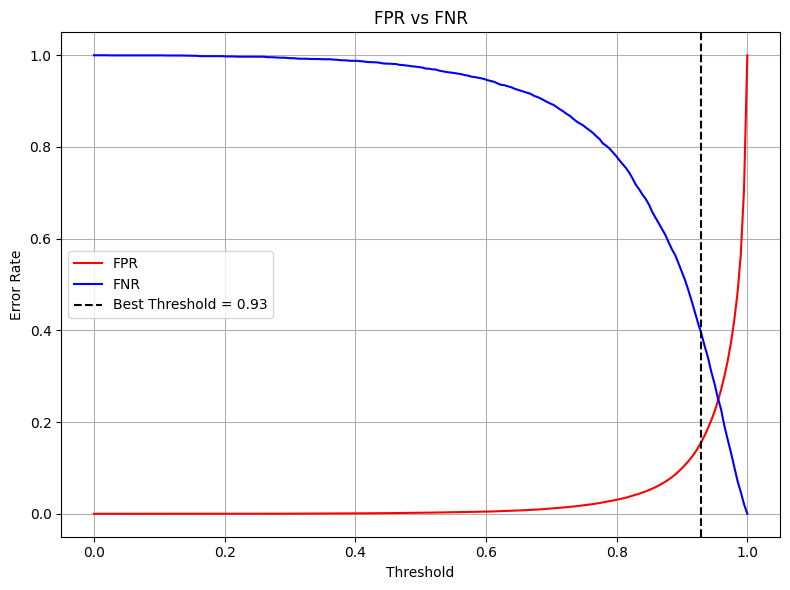

0.15662534135670791 0.39273648648538084
Test results
Accuracy: 0.8336577453365774
Classification Report:
               precision    recall  f1-score   support

         0.0       0.14      0.61      0.23      3552
         1.0       0.98      0.84      0.91     82758

    accuracy                           0.83     86310
   macro avg       0.56      0.73      0.57     86310
weighted avg       0.95      0.83      0.88     86310

Weighted F1 Score: 0.878934578852399
Confusion Matrix Report:
 [[ 2157  1395]
 [12962 69796]]


In [54]:
##########################################################################################
# Train your final model on the entire training set
model_xg_boost.fit(x_train, y_train_bin)

# Predict probabilities on the test set
test_probs = model_xg_boost.predict_proba(x_test)[:, 1]

threshold, fpr_val, fnr_val = fast_balanced_threshold(y_test_bin, test_probs, max_fpr=0.16)

# 0.12 0.16

print(fpr_val, fnr_val)


y_test_pred = (test_probs >= threshold).astype(int)

# Compute metrics
acc = accuracy_score(y_test_bin, y_test_pred)
report = classification_report(y_test_bin, y_test_pred)
matrix = confusion_matrix(y_test_bin, y_test_pred)
f1 = f1_score(y_test_bin, y_test_pred, average='weighted')


print("Test results")
print("Accuracy:", acc)
print("Classification Report:\n", report)
print("Weighted F1 Score:", f1)
print("Confusion Matrix Report:\n", matrix)

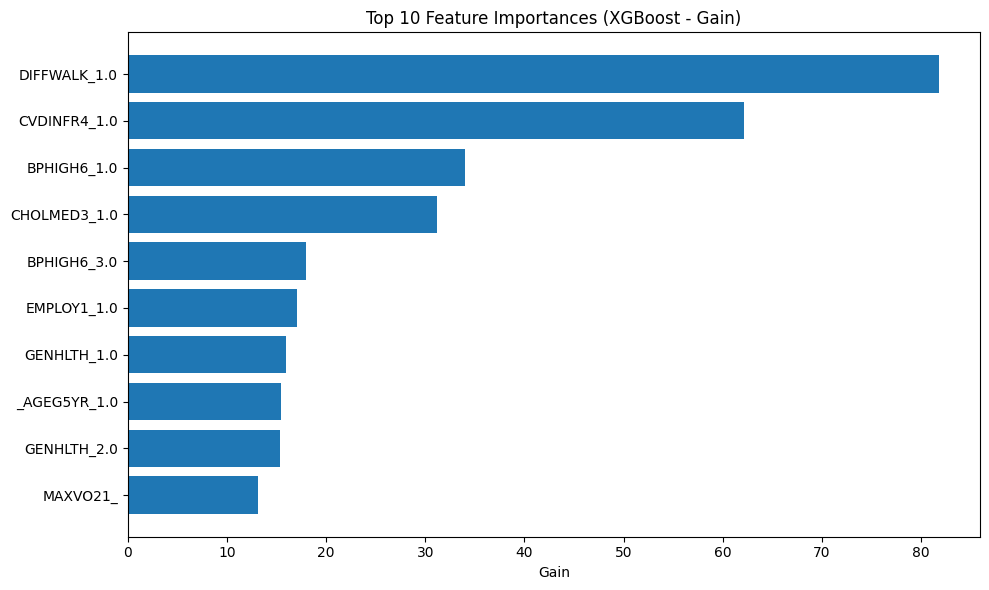

In [55]:
import pandas as pd
import matplotlib.pyplot as plt

# Get feature importance based on 'gain' from the XGBoost model
importance_dict = model_xg_boost.get_booster().get_score(importance_type='gain')
importance_df = pd.DataFrame({
    'Feature': list(importance_dict.keys()),
    'Importance': list(importance_dict.values())
}).sort_values(by='Importance', ascending=False)

# Select top 10 most important features
top_n = 10
top_features = importance_df.head(top_n)

# Plot the top N features as a horizontal bar chart
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'][::-1], top_features['Importance'][::-1])  # Reverse to show most important on top
plt.xlabel("Gain")
plt.title(f"Top {top_n} Feature Importances (XGBoost - Gain)")
plt.tight_layout()
plt.show()

# Random Forest Classification

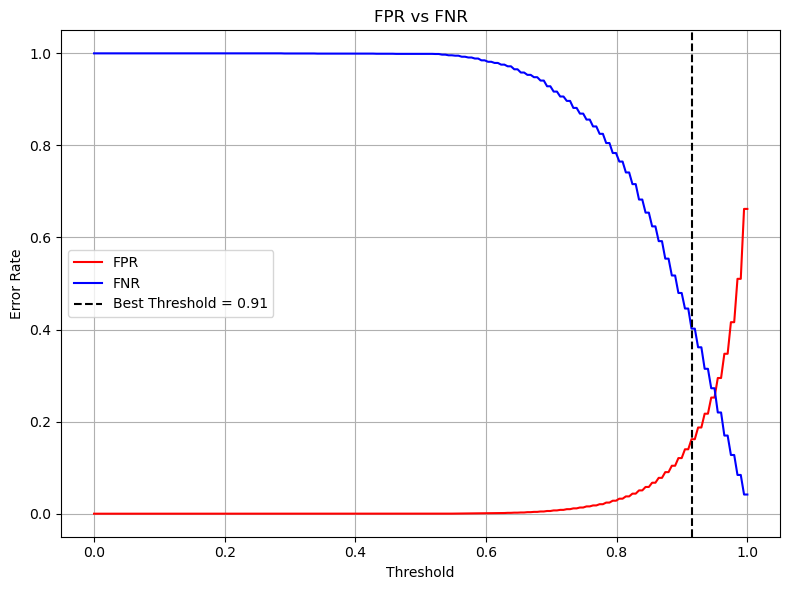

0.1618212136590829 0.4020270270258952
Test results
Accuracy: 0.8282933611400765
Classification Report:
               precision    recall  f1-score   support

         0.0       0.14      0.60      0.22      3552
         1.0       0.98      0.84      0.90     82758

    accuracy                           0.83     86310
   macro avg       0.56      0.72      0.56     86310
weighted avg       0.95      0.83      0.88     86310

Weighted F1 Score: 0.8754717920766943
Confusion Matrix Report:
 [[ 2124  1428]
 [13392 69366]]


In [383]:
##########################################################################################
# Train your final model on the entire training set
model_rf.fit(x_train, y_train_bin)

# Predict probabilities on the test set
test_probs = model_rf.predict_proba(x_test)[:, 1]

threshold, fpr_val, fnr_val = fast_balanced_threshold(y_test_bin, test_probs, max_fpr=0.18)

# 0.20

print(fpr_val, fnr_val)

y_test_pred = (test_probs >= threshold).astype(int)

# Compute metrics
acc = accuracy_score(y_test_bin, y_test_pred)
report = classification_report(y_test_bin, y_test_pred)
matrix = confusion_matrix(y_test_bin, y_test_pred)
f1 = f1_score(y_test_bin, y_test_pred, average='weighted')


print("Test results")
print("Accuracy:", acc)
print("Classification Report:\n", report)
print("Weighted F1 Score:", f1)
print("Confusion Matrix Report:\n", matrix)

# Commorbidity_2: High Blood Pressure/Hypertention

In [162]:
comorbidities_bp_cdc2023.sample(6)

,_STATE,SEXVAR,GENHLTH,PHYSHLTH,MENTHLTH,POORHLTH,PRIMINS1,MEDCOST1,CHECKUP1,EXERANY2,EXRACT12,EXEROFT1,BPHIGH6,BPMEDS1,CHOLCHK3,TOLDHI3,CHOLMED3,CVDINFR4,CVDCRHD4,CVDSTRK3,ASTHMA3,ASTHNOW,CHCSCNC1,CHCOCNC1,CHCCOPD3,ADDEPEV3,CHCKDNY2,HAVARTH4,DIABETE4,DIABAGE4,MARITAL,EDUCA,VETERAN3,EMPLOY1,CHILDREN,INCOME3,PREGNANT,DEAF,BLIND,DECIDE,DIFFWALK,DIFFDRES,DIFFALON,FALLINJ5,USENOW3,ECIGNOW2,FLUSHOT7,PNEUVAC4,SHINGLE2,HIVTST7,SEATBELT,COVIDPO1,COVIDSM1,PREDIAB2,INSULIN1,CHKHEMO3,DIABEYE1,DIABEDU1,FEETSORE,ARTHDIS2,LCSCTSC1,CAREGIV1,HEATTBCO,ASPIRIN,ACEDIVRC,COVIDVA1,COVIDNU2,EMTSUPRT,SDLONELY,SDHEMPLY,FOODSTMP,SDHFOOD1,SDHSTRE1,_URBSTAT,_IMPRACE,MAXVO21_,ACTIN13_,ACTIN23_,PADUR1_,STRFREQ_,_PACAT3,_PA300R4,_PAREC3,_RFHYPE6,_LTASTH1,_MRACE1,_AGEG5YR,HTM4,WTKG3,_BMI5CAT,_SMOKER3,_CURECI2,DRNKANY6,_RFDRHV8,_DRNKDRV
241676,33.000000,2.000000,2.000000,0.000000,0.000000,0.000000,7.000000,2.000000,1.000000,1.000000,3.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,3.000000,60.000000,1.000000,6.000000,2.000000,7.000000,2.000000,6.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.000000,3.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,2.000000,3.000000,2.000000,2.000000,2.000000,8.000000,2.000000,2.000000,1.000000,2.000000,2.000000,4.000000,2.000000,1.000000,4.000000,1.000000,5.000000,2.000000,2.000000,5.000000,3.000000,1.000000,1.000000,22.100000,2.000000,2.000000,120.000000,3.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,11.000000,1.570000,76.200000,4.000000,4.000000,1.000000,1.000000,1.000000,2.000000
169484,24.000000,1.000000,3.000000,3.000000,0.000000,3.000000,1.000000,2.000000,1.000000,1.000000,11.000000,2.000000,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,32.000000,6.000000,6.000000,2.000000,1.000000,2.000000,10.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.000000,3.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,2.000000,2.000000,3.000000,2.000000,2.000000,2.000000,8.000000,2.000000,2.000000,2.000000,2.000000,2.000000,4.000000,2.000000,1.000000,3.000000,1.000000,5.000000,2.000000,2.000000,5.000000,5.000000,1.000000,1.000000,33.600000,1.000000,2.000000,30.000000,0.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,6.000000,1.850000,127.010000,4.000000,4.000000,1.000000,1.000000,1.000000,2.000000
264257,36.000000,1.000000,2.000000,0.000000,2.000000,0.000000,1.000000,2.000000,1.000000,1.000000,1.000000,3.000000,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,37.000000,6.000000,5.000000,2.000000,1.000000,1.000000,8.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.000000,3.000000,4.000000,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,3.000000,2.000000,2.000000,2.000000,8.000000,2.000000,2.000000,2.000000,2.000000,2.000000,4.000000,2.000000,1.000000,3.000000,1.000000,5.000000,2.000000,2.000000,5.000000,5.000000,1.000000,1.000000,35.800000,1.000000,1.000000,30.000000,0.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,5.000000,2.030000,158.760000,4.000000,2.000000,1.000000,1.000000,1.000000,2.000000
332211,46.000000,2.000000,4.000000,3.000000,0.000000,0.000000,3.000000,2.000000,1.000000,1.000000,3.000000,4.000000,1.000000,1.000000,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,3.000000,60.000000,1.000000,5.000000,2.000000,7.000000,2.000000,7.000000,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,0.000000,3.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,2.000000,3.000000,2.000000,2.000000,2.000000,8.000000,2.000000,2.000000,1.000000,2.000000,1.000000,

In [163]:
comorbidities_bp_cdc2023.info()

<class 'pandas.core.frame.DataFrame'>
Index: 431549 entries, 0 to 433322
Data columns (total 95 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   _STATE    431549 non-null  category
 1   SEXVAR    431549 non-null  category
 2   GENHLTH   431549 non-null  category
 3   PHYSHLTH  431549 non-null  float64 
 4   MENTHLTH  431549 non-null  float64 
 5   POORHLTH  431549 non-null  float64 
 6   PRIMINS1  431549 non-null  category
 7   MEDCOST1  431549 non-null  category
 8   CHECKUP1  431549 non-null  category
 9   EXERANY2  431549 non-null  category
 10  EXRACT12  431549 non-null  category
 11  EXEROFT1  431549 non-null  float64 
 12  BPHIGH6   431549 non-null  category
 13  BPMEDS1   431549 non-null  category
 14  CHOLCHK3  431549 non-null  category
 15  TOLDHI3   431549 non-null  category
 16  CHOLMED3  431549 non-null  category
 17  CVDINFR4  431549 non-null  category
 18  CVDCRHD4  431549 non-null  category
 19  CVDSTRK3  431549 non-null  c

In [164]:
for col in comorbidities_bp_cdc2023.columns:
    print(f"Unique values for {col}:")
    print(comorbidities_bp_cdc2023[col].unique())
    print("-----------------------------------------------------")

Unique values for _STATE:
[1.000000, 2.000000, 4.000000, 5.000000, 6.000000, ..., 55.000000, 56.000000, 66.000000, 72.000000, 78.000000]
Length: 51
Categories (51, float64): [1.000000, 2.000000, 4.000000, 5.000000, ..., 56.000000, 66.000000, 72.000000, 78.000000]
-----------------------------------------------------
Unique values for SEXVAR:
[2.000000, 1.000000]
Categories (2, float64): [1.000000, 2.000000]
-----------------------------------------------------
Unique values for GENHLTH:
[2.000000, 4.000000, 3.000000, 5.000000, 1.000000]
Categories (5, float64): [1.000000, 2.000000, 3.000000, 4.000000, 5.000000]
-----------------------------------------------------
Unique values for PHYSHLTH:
[ 0.  6.  2.  8.  1.  5.  4. 30. 15. 21. 10. 25. 14.  7. 20. 88.  3. 12.
 26.  9. 24. 18. 13. 28. 23. 16. 17. 11. 29. 27. 22. 19.]
-----------------------------------------------------
Unique values for MENTHLTH:
[ 0.  2.  3. 88. 10. 25.  5. 30. 20. 15. 12.  4.  1.  6. 21. 14.  7. 29.
  8. 18. 16. 

In [165]:

# Get the list of numeric columns (which includes int, float, etc.)
numeric_columns = comorbidities_bp_cdc2023.select_dtypes(include=[np.number]).columns.tolist()

# Get the list of categorical columns.

categorical_columns = comorbidities_bp_cdc2023.select_dtypes(include=['category', 'object']).columns.tolist()

print("Numeric columns:")
print(numeric_columns)
print("-----------------------------------------------------")
print("Categorical columns:")
print(categorical_columns)


Numeric columns:
['PHYSHLTH', 'MENTHLTH', 'POORHLTH', 'EXEROFT1', 'DIABAGE4', 'EDUCA', 'CHILDREN', 'INCOME3', 'FALLINJ5', 'CHKHEMO3', 'COVIDNU2', 'MAXVO21_', 'ACTIN13_', 'ACTIN23_', 'PADUR1_', 'STRFREQ_', 'HTM4', 'WTKG3']
-----------------------------------------------------
Categorical columns:
['_STATE', 'SEXVAR', 'GENHLTH', 'PRIMINS1', 'MEDCOST1', 'CHECKUP1', 'EXERANY2', 'EXRACT12', 'BPHIGH6', 'BPMEDS1', 'CHOLCHK3', 'TOLDHI3', 'CHOLMED3', 'CVDINFR4', 'CVDCRHD4', 'CVDSTRK3', 'ASTHMA3', 'ASTHNOW', 'CHCSCNC1', 'CHCOCNC1', 'CHCCOPD3', 'ADDEPEV3', 'CHCKDNY2', 'HAVARTH4', 'DIABETE4', 'MARITAL', 'VETERAN3', 'EMPLOY1', 'PREGNANT', 'DEAF', 'BLIND', 'DECIDE', 'DIFFWALK', 'DIFFDRES', 'DIFFALON', 'USENOW3', 'ECIGNOW2', 'FLUSHOT7', 'PNEUVAC4', 'SHINGLE2', 'HIVTST7', 'SEATBELT', 'COVIDPO1', 'COVIDSM1', 'PREDIAB2', 'INSULIN1', 'DIABEYE1', 'DIABEDU1', 'FEETSORE', 'ARTHDIS2', 'LCSCTSC1', 'CAREGIV1', 'HEATTBCO', 'ASPIRIN', 'ACEDIVRC', 'COVIDVA1', 'EMTSUPRT', 'SDLONELY', 'SDHEMPLY', 'FOODSTMP', 'SDHFO

In [166]:
# Loop over the categorical columns
for col in categorical_columns:
    if comorbidities_bp_cdc2023[col].dtype.name == 'category':
        try:
            # Build a new list of categories by converting each category value to int
            new_categories = [int(float(c)) for c in comorbidities_bp_cdc2023[col].cat.categories]
            # Update the categorical column using rename_categories
            comorbidities_bp_cdc2023[col] = comorbidities_bp_cdc2023[col].cat.rename_categories(new_categories)
        except Exception as e:
            print(f"Could not rename categories for column {col}: {e}")


In [167]:
# Loop over each categorical column and print its unique values
for col in categorical_columns:
    print(f"Unique values for {col}:")
    print(comorbidities_bp_cdc2023[col].unique())
    print("-----------------------------------------------------")

Unique values for _STATE:
[1, 2, 4, 5, 6, ..., 55, 56, 66, 72, 78]
Length: 51
Categories (51, int64): [1, 2, 4, 5, ..., 56, 66, 72, 78]
-----------------------------------------------------
Unique values for SEXVAR:
[2, 1]
Categories (2, int64): [1, 2]
-----------------------------------------------------
Unique values for GENHLTH:
[2, 4, 3, 5, 1]
Categories (5, int64): [1, 2, 3, 4, 5]
-----------------------------------------------------
Unique values for PRIMINS1:
[3, 7, 1, 2, 88, ..., 9, 4, 5, 8, 6]
Length: 11
Categories (11, int64): [1, 2, 3, 4, ..., 8, 9, 10, 88]
-----------------------------------------------------
Unique values for MEDCOST1:
[2, 1]
Categories (2, int64): [1, 2]
-----------------------------------------------------
Unique values for CHECKUP1:
[2, 1, 3, 8, 4]
Categories (5, int64): [1, 2, 3, 4, 8]
-----------------------------------------------------
Unique values for EXERANY2:
[2, 1]
Categories (2, int64): [1, 2]
--------------------------------------------------

In [168]:
categorical_columns.remove('BPHIGH6')
categorical_columns.remove('_RFHYPE6')


comorbidities_bp_cdc2023 = pd.get_dummies(comorbidities_bp_cdc2023, columns=categorical_columns, drop_first=False, dtype=int)


# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the scaler on the numerical columns of the training set and transform them
comorbidities_bp_cdc2023[numeric_columns] = scaler.fit_transform(comorbidities_bp_cdc2023[numeric_columns])

# Check the results
print("Scaled Data:")
comorbidities_bp_cdc2023.sample(5)

Scaled Data:


,PHYSHLTH,MENTHLTH,POORHLTH,EXEROFT1,BPHIGH6,DIABAGE4,EDUCA,CHILDREN,INCOME3,FALLINJ5,CHKHEMO3,COVIDNU2,MAXVO21_,ACTIN13_,ACTIN23_,PADUR1_,STRFREQ_,_RFHYPE6,HTM4,WTKG3,_STATE_1,_STATE_2,_STATE_4,_STATE_5,_STATE_6,_STATE_8,_STATE_10,_STATE_11,_STATE_12,_STATE_13,_STATE_15,_STATE_16,_STATE_17,_STATE_18,_STATE_19,_STATE_20,_STATE_22,_STATE_23,_STATE_24,_STATE_25,_STATE_26,_STATE_27,_STATE_28,_STATE_29,_STATE_30,_STATE_31,_STATE_32,_STATE_33,_STATE_34,_STATE_35,_STATE_36,_STATE_37,_STATE_38,_STATE_39,_STATE_40,_STATE_41,_STATE_44,_STATE_45,_STATE_46,_STATE_47,_STATE_48,_STATE_49,_STATE_50,_STATE_51,_STATE_53,_STATE_54,_STATE_55,_STATE_56,_STATE_66,_STATE_72,_STATE_78,SEXVAR_1,SEXVAR_2,GENHLTH_1,GENHLTH_2,GENHLTH_3,GENHLTH_4,GENHLTH_5,PRIMINS1_1,PRIMINS1_2,PRIMINS1_3,PRIMINS1_4,PRIMINS1_5,PRIMINS1_6,PRIMINS1_7,PRIMINS1_8,PRIMINS1_9,PRIMINS1_10,PRIMINS1_88,MEDCOST1_1,MEDCOST1_2,CHECKUP1_1,CHECKUP1_2,CHECKUP1_3,CHECKUP1_4,CHECKUP1_8,EXERANY2_1,EXERANY2_2,EXRACT12_1,EXRACT12_2,EXRACT12_3,EXRACT12_4,EXRACT12_5,EXRACT12_6,EXRACT12_7,EXRACT12_8,EXRACT12_9,EXRACT12_10,EXRACT12_11,BPMEDS1_1,BPMEDS1_2,CHOLCHK3_1,CHOLCHK3_2,CHOLCHK3_3,CHOLCHK3_4,CHOLCHK3_5,CHOLCHK3_6,CHOLCHK3_8,TOLDHI3_1,TOLDHI3_2,CHOLMED3_1,CHOLMED3_2,CVDINFR4_1,CVDINFR4_2,CVDCRHD4_1,CVDCRHD4_2,CVDSTRK3_1,CVDSTRK3_2,ASTHMA3_1,ASTHMA3_2,ASTHNOW_1,ASTHNOW_2,CHCSCNC1_1,CHCSCNC1_2,CHCOCNC1_1,CHCOCNC1_2,CHCCOPD3_1,CHCCOPD3_2,ADDEPEV3_1,ADDEPEV3_2,CHCKDNY2_1,CHCKDNY2_2,HAVARTH4_1,HAVARTH4_2,DIABETE4_1,DIABETE4_2,DIABETE4_3,DIABETE4_4,DIABETE4_7,DIABETE4_9,MARITAL_1,MARITAL_2,MARITAL_3,MARITAL_4,MARITAL_5,MARITAL_6,VETERAN3_1,VETERAN3_2,EMPLOY1_1,EMPLOY1_2,EMPLOY1_3,EMPLOY1_4,EMPLOY1_5,EMPLOY1_6,EMPLOY1_7,EMPLOY1_8,PREGNANT_1,PREGNANT_2,DEAF_1,DEAF_2,BLIND_1,BLIND_2,DECIDE_1,DECIDE_2,DIFFWALK_1,DIFFWALK_2,DIFFDRES_1,DIFFDRES_2,DIFFALON_1,DIFFALON_2,USENOW3_1,USENOW3_2,USENOW3_3,ECIGNOW2_1,ECIGNOW2_2,ECIGNOW2_3,ECIGNOW2_4,FLUSHOT7_1,FLUSHOT7_2,PNEUVAC4_1,PNEUVAC4_2,SHINGLE2_1,SHINGLE2_2,HIVTST7_1,HIVTST7_2,SEATBELT_1,SEATBELT_2,SEATBELT_3,SEATBELT_4,SEATBELT_5,SEATBELT_8,COVIDPO1_1,COVIDPO1_2,COVIDSM1_1,COVIDSM1_2,PREDIAB2_1,PREDIAB2_2,PREDIAB2_3,PREDIAB2_7,PREDIAB2_9,INSULIN1_1,INSULIN1_2,DIABEYE1_1,DIABEYE1_2,DIABEYE1_3,DIABEYE1_4,DIABEYE1_8,DIABEDU1_1,DIABEDU1_2,DIABEDU1_3,DIABEDU1_4,DIABEDU1_5,DIABEDU1_6,DIABEDU1_8,FEETSORE_1,FEETSORE_2,ARTHDIS2_1,ARTHDIS2_2,LCSCTSC1_1,LCSCTSC1_2,CAREGIV1_1,CAREGIV1_2,CAREGIV1_8,HEATTBCO_1,HEATTBCO_2,ASPIRIN_1,ASPIRIN_2,ASPIRIN_3,ASPIRIN_4,ACEDIVRC_1,ACEDIVRC_2,ACEDIVRC_8,COVIDVA1_1,COVIDVA1_2,EMTSUPRT_1,EMTSUPRT_2,EMTSUPRT_3,EMTSUPRT_4,EMTSUPRT_5,SDLONELY_1,SDLONELY_2,SDLONELY_3,SDLONELY_4,SDLONELY_5,SDHEMPLY_1,SDHEMPLY_2,FOODSTMP_1,FOODSTMP_2,SDHFOOD1_1,SDHFOOD1_2,SDHFOOD1_3,SDHFOOD1_4,SDHFOOD1_5,SDHSTRE1_1,SDHSTRE1_2,SDHSTRE1_3,SDHSTRE1_4,SDHSTRE1_5,_URBSTAT_1,_URBSTAT_2,_IMPRACE_1,_IMPRACE_2,_IMPRACE_3,_IMPRACE_4,_IMPRACE_5,_IMPRACE_6,_PACAT3_1,_PACAT3_2,_PACAT3_3,_PACAT3_4,_PA300R4_1,_PA300R4_2,_PA300R4_3,_PAREC3_1,_PAREC3_2,_PAREC3_3,_PAREC3_4,_LTASTH1_1,_LTASTH1_2,_MRACE1_1,_MRACE1_2,_MRACE1_3,_MRACE1_4,_MRACE1_5,_MRACE1_6,_MRACE1_7,_AGEG5YR_1,_AGEG5YR_2,_AGEG5YR_3,_AGEG5YR_4,_AGEG5YR_5,_AGEG5YR_6,_AGEG5YR_7,_AGEG5YR_8,_AGEG5YR_9,_AGEG5YR_10,_AGEG5YR_11,_AGEG5YR_12,_AGEG5YR_13,_BMI5CAT_1,_BMI5CAT_2,_BMI5CAT_3,_BMI5CAT_4,_SMOKER3_1,_SMOKER3_2,_SMOKER3_3,_SMOKER3_4,_CURECI2_1,_CURECI2_2,DRNKANY6_1,DRNKANY6_2,_RFDRHV8_1,_RFDRHV8_2,_DRNKDRV_1,_DRNKDRV_2
403287,-0.418703,-0.422792,-0.358082,-1.224743,3,-0.795163,0.948911,-1.749493,1.362500,-0.159465,-0.096593,-0.042405,1.164040,-0.440204,-0.552655,1.613725,0.323186,1,0.741277,2.053215,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,1,0,1,0,1,0,1,0,1,1,0,0,1,0,1,0,1,0,1,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,0,0,1,0,0,1,0,1,0,1,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1

In [169]:
# Split the dataset into 80% training and 20% testing sets
train, test = train_test_split(comorbidities_bp_cdc2023, test_size=0.20, random_state=42)

# Check the shapes of the splits
print("Training set shape:", train.shape)
print("Test set shape:", test.shape)

Training set shape: (345239, 325)
Test set shape: (86310, 325)


In [171]:
y_train_bin = train['BPHIGH6']
y_test_bin = test['BPHIGH6']


x_train = train.drop(columns=['BPHIGH6', '_RFHYPE6'], axis=1)

x_test = test.drop(columns=['BPHIGH6', '_RFHYPE6'], axis=1)

x_test.head()

,PHYSHLTH,MENTHLTH,POORHLTH,EXEROFT1,DIABAGE4,EDUCA,CHILDREN,INCOME3,FALLINJ5,CHKHEMO3,COVIDNU2,MAXVO21_,ACTIN13_,ACTIN23_,PADUR1_,STRFREQ_,HTM4,WTKG3,_STATE_1,_STATE_2,_STATE_4,_STATE_5,_STATE_6,_STATE_8,_STATE_10,_STATE_11,_STATE_12,_STATE_13,_STATE_15,_STATE_16,_STATE_17,_STATE_18,_STATE_19,_STATE_20,_STATE_22,_STATE_23,_STATE_24,_STATE_25,_STATE_26,_STATE_27,_STATE_28,_STATE_29,_STATE_30,_STATE_31,_STATE_32,_STATE_33,_STATE_34,_STATE_35,_STATE_36,_STATE_37,_STATE_38,_STATE_39,_STATE_40,_STATE_41,_STATE_44,_STATE_45,_STATE_46,_STATE_47,_STATE_48,_STATE_49,_STATE_50,_STATE_51,_STATE_53,_STATE_54,_STATE_55,_STATE_56,_STATE_66,_STATE_72,_STATE_78,SEXVAR_1,SEXVAR_2,GENHLTH_1,GENHLTH_2,GENHLTH_3,GENHLTH_4,GENHLTH_5,PRIMINS1_1,PRIMINS1_2,PRIMINS1_3,PRIMINS1_4,PRIMINS1_5,PRIMINS1_6,PRIMINS1_7,PRIMINS1_8,PRIMINS1_9,PRIMINS1_10,PRIMINS1_88,MEDCOST1_1,MEDCOST1_2,CHECKUP1_1,CHECKUP1_2,CHECKUP1_3,CHECKUP1_4,CHECKUP1_8,EXERANY2_1,EXERANY2_2,EXRACT12_1,EXRACT12_2,EXRACT12_3,EXRACT12_4,EXRACT12_5,EXRACT12_6,EXRACT12_7,EXRACT12_8,EXRACT12_9,EXRACT12_10,EXRACT12_11,BPMEDS1_1,BPMEDS1_2,CHOLCHK3_1,CHOLCHK3_2,CHOLCHK3_3,CHOLCHK3_4,CHOLCHK3_5,CHOLCHK3_6,CHOLCHK3_8,TOLDHI3_1,TOLDHI3_2,CHOLMED3_1,CHOLMED3_2,CVDINFR4_1,CVDINFR4_2,CVDCRHD4_1,CVDCRHD4_2,CVDSTRK3_1,CVDSTRK3_2,ASTHMA3_1,ASTHMA3_2,ASTHNOW_1,ASTHNOW_2,CHCSCNC1_1,CHCSCNC1_2,CHCOCNC1_1,CHCOCNC1_2,CHCCOPD3_1,CHCCOPD3_2,ADDEPEV3_1,ADDEPEV3_2,CHCKDNY2_1,CHCKDNY2_2,HAVARTH4_1,HAVARTH4_2,DIABETE4_1,DIABETE4_2,DIABETE4_3,DIABETE4_4,DIABETE4_7,DIABETE4_9,MARITAL_1,MARITAL_2,MARITAL_3,MARITAL_4,MARITAL_5,MARITAL_6,VETERAN3_1,VETERAN3_2,EMPLOY1_1,EMPLOY1_2,EMPLOY1_3,EMPLOY1_4,EMPLOY1_5,EMPLOY1_6,EMPLOY1_7,EMPLOY1_8,PREGNANT_1,PREGNANT_2,DEAF_1,DEAF_2,BLIND_1,BLIND_2,DECIDE_1,DECIDE_2,DIFFWALK_1,DIFFWALK_2,DIFFDRES_1,DIFFDRES_2,DIFFALON_1,DIFFALON_2,USENOW3_1,USENOW3_2,USENOW3_3,ECIGNOW2_1,ECIGNOW2_2,ECIGNOW2_3,ECIGNOW2_4,FLUSHOT7_1,FLUSHOT7_2,PNEUVAC4_1,PNEUVAC4_2,SHINGLE2_1,SHINGLE2_2,HIVTST7_1,HIVTST7_2,SEATBELT_1,SEATBELT_2,SEATBELT_3,SEATBELT_4,SEATBELT_5,SEATBELT_8,COVIDPO1_1,COVIDPO1_2,COVIDSM1_1,COVIDSM1_2,PREDIAB2_1,PREDIAB2_2,PREDIAB2_3,PREDIAB2_7,PREDIAB2_9,INSULIN1_1,INSULIN1_2,DIABEYE1_1,DIABEYE1_2,DIABEYE1_3,DIABEYE1_4,DIABEYE1_8,DIABEDU1_1,DIABEDU1_2,DIABEDU1_3,DIABEDU1_4,DIABEDU1_5,DIABEDU1_6,DIABEDU1_8,FEETSORE_1,FEETSORE_2,ARTHDIS2_1,ARTHDIS2_2,LCSCTSC1_1,LCSCTSC1_2,CAREGIV1_1,CAREGIV1_2,CAREGIV1_8,HEATTBCO_1,HEATTBCO_2,ASPIRIN_1,ASPIRIN_2,ASPIRIN_3,ASPIRIN_4,ACEDIVRC_1,ACEDIVRC_2,ACEDIVRC_8,COVIDVA1_1,COVIDVA1_2,EMTSUPRT_1,EMTSUPRT_2,EMTSUPRT_3,EMTSUPRT_4,EMTSUPRT_5,SDLONELY_1,SDLONELY_2,SDLONELY_3,SDLONELY_4,SDLONELY_5,SDHEMPLY_1,SDHEMPLY_2,FOODSTMP_1,FOODSTMP_2,SDHFOOD1_1,SDHFOOD1_2,SDHFOOD1_3,SDHFOOD1_4,SDHFOOD1_5,SDHSTRE1_1,SDHSTRE1_2,SDHSTRE1_3,SDHSTRE1_4,SDHSTRE1_5,_URBSTAT_1,_URBSTAT_2,_IMPRACE_1,_IMPRACE_2,_IMPRACE_3,_IMPRACE_4,_IMPRACE_5,_IMPRACE_6,_PACAT3_1,_PACAT3_2,_PACAT3_3,_PACAT3_4,_PA300R4_1,_PA300R4_2,_PA300R4_3,_PAREC3_1,_PAREC3_2,_PAREC3_3,_PAREC3_4,_LTASTH1_1,_LTASTH1_2,_MRACE1_1,_MRACE1_2,_MRACE1_3,_MRACE1_4,_MRACE1_5,_MRACE1_6,_MRACE1_7,_AGEG5YR_1,_AGEG5YR_2,_AGEG5YR_3,_AGEG5YR_4,_AGEG5YR_5,_AGEG5YR_6,_AGEG5YR_7,_AGEG5YR_8,_AGEG5YR_9,_AGEG5YR_10,_AGEG5YR_11,_AGEG5YR_12,_AGEG5YR_13,_BMI5CAT_1,_BMI5CAT_2,_BMI5CAT_3,_BMI5CAT_4,_SMOKER3_1,_SMOKER3_2,_SMOKER3_3,_SMOKER3_4,_CURECI2_1,_CURECI2_2,DRNKANY6_1,DRNKANY6_2,_RFDRHV8_1,_RFDRHV8_2,_DRNKDRV_1,_DRNKDRV_2
56691,-0.162329,-0.279159,-0.275095,1.363449,-2.339175,0.948911,0.030154,0.453020,-0.159465,0.716841,3.520613,1.186937,-0.440204,-0.552655,-0.131580,-0.531276,-1.264696,-1.046692,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,1,0,1,0,1,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,0,0,1,0,0,1,0,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,1,0,0,1,0,0,0,1

# Hypertension Classification

In [172]:
#check unique values for 'BPHIGH6'
unique_values = comorbidities_bp_cdc2023['BPHIGH6'].unique()
print(unique_values)

[1, 3, 2, 4]
Categories (4, int64): [1, 2, 3, 4]


In [173]:
# Map labels: 1,2 → 1, 3, 4 → 0 (just for the model)
y_train_bin = y_train_bin.replace({1: 1, 2: 1, 3: 0, 4: 0})
y_test_bin = y_test_bin.replace({1: 1, 2: 1, 3: 0, 4: 0})


C:\Users\liuya\AppData\Local\Temp\ipykernel_29648\162228568.py:2: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  y_train_bin = y_train_bin.replace({1: 1, 2: 1, 3: 0, 4: 0})
C:\Users\liuya\AppData\Local\Temp\ipykernel_29648\162228568.py:3: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  y_test_bin = y_test_bin.replace({1: 1, 2: 1, 3: 0, 4: 0})


# Without Accounting For Class Imbalance

XGBoost Classification

In [174]:
# Define evaluation metrics (using macro averaging to account for imbalanced classes)
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision_macro',
    'recall': 'recall_macro',
    'f1': 'f1_macro'
}

# Use Stratified K-Fold cross-validation to preserve class imbalance in the binary target
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

model_xg_boost = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', objective='multi:softmax', num_class=2)

cv_xgboost_results = cross_validate(model_xg_boost, x_train, y_train_bin, cv=skf, scoring=scoring, n_jobs=-1)



print(f"xgboost cross-validated results: - Accuracy: {np.mean(cv_xgboost_results['test_accuracy']):.4f}, "
        f"Precision: {np.mean(cv_xgboost_results['test_precision']):.4f}, "
        f"Recall: {np.mean(cv_xgboost_results['test_recall']):.4f}, "
        f"F1: {np.mean(cv_xgboost_results['test_f1']):.4f}")
print("---------------------------------------------------")


# Train the model on the full training set
model_xg_boost.fit(x_train, y_train_bin)

y_test_pred_xgboost = model_xg_boost.predict(x_test)


# Compute metrics
acc = accuracy_score(y_test_bin, y_test_pred_xgboost)
report = classification_report(y_test_bin, y_test_pred_xgboost)
matrix = confusion_matrix(y_test_bin, y_test_pred_xgboost)
f1 = f1_score(y_test_bin, y_test_pred_xgboost, average='weighted')


print("Test results")
print("Accuracy:", acc)
print("Classification Report:\n", report)
print("Weighted F1 Score:", f1)
print("Confusion Matrix Report:\n", matrix)

xgboost cross-validated results: - Accuracy: 0.7787, Precision: 0.7730, Recall: 0.7681, F1: 0.7701
---------------------------------------------------


C:\Users\liuya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\core.py:158: UserWarning: [22:49:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Test results
Accuracy: 0.7797010775112965
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.83      0.82     50698
           1       0.75      0.70      0.72     35612

    accuracy                           0.78     86310
   macro avg       0.77      0.77      0.77     86310
weighted avg       0.78      0.78      0.78     86310

Weighted F1 Score: 0.7785343041951336
Confusion Matrix Report:
 [[42287  8411]
 [10603 25009]]


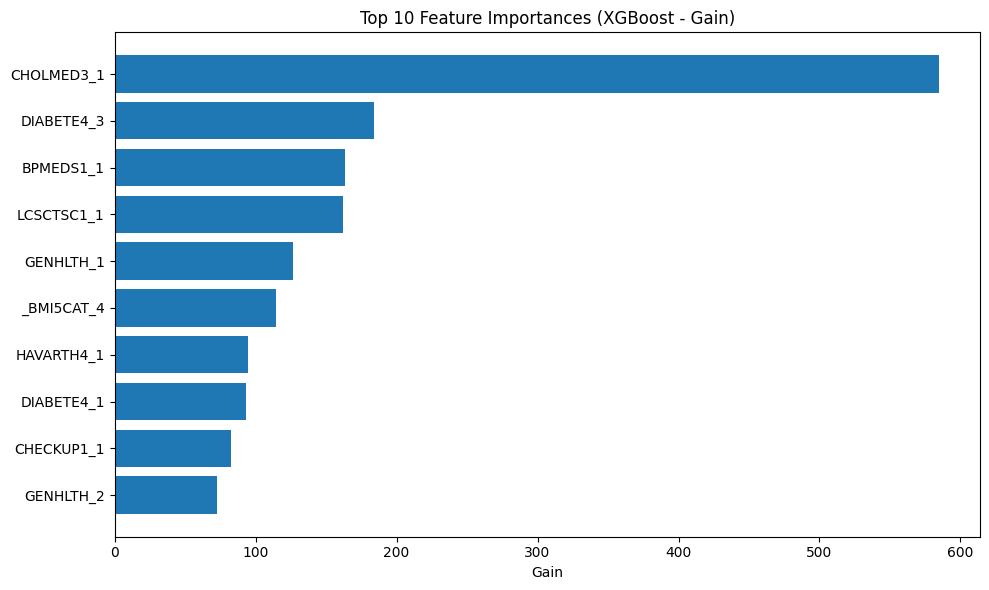

In [175]:
import pandas as pd
import matplotlib.pyplot as plt

# Get feature importance based on 'gain' from the XGBoost model
importance_dict = model_xg_boost.get_booster().get_score(importance_type='gain')
importance_df = pd.DataFrame({
    'Feature': list(importance_dict.keys()),
    'Importance': list(importance_dict.values())
}).sort_values(by='Importance', ascending=False)

# Select top 10 most important features
top_n = 10
top_features = importance_df.head(top_n)

# Plot the top N features as a horizontal bar chart
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'][::-1], top_features['Importance'][::-1])  # Reverse to show most important on top
plt.xlabel("Gain")
plt.title(f"Top {top_n} Feature Importances (XGBoost - Gain)")
plt.tight_layout()
plt.show()


Random Forest Classification

In [177]:
model_rf = RandomForestClassifier(n_jobs=-1)

cv_rf_results = cross_validate(model_rf, x_train, y_train_bin, cv=skf, scoring=scoring, n_jobs=-1)


print(f"Random Forest - Accuracy: {np.mean(cv_rf_results['test_accuracy']):.4f}, "
        f"Precision: {np.mean(cv_rf_results['test_precision']):.4f}, "
        f"Recall: {np.mean(cv_rf_results['test_recall']):.4f}, "
        f"F1: {np.mean(cv_rf_results['test_f1']):.4f}")
print("---------------------------------------------------")


# Train the model on the full training set
model_rf.fit(x_train, y_train_bin)

y_test_prob = model_rf.predict_proba(x_test)

y_test_pred_rf = model_rf.predict(x_test)


# Compute metrics
acc = accuracy_score(y_test_bin, y_test_pred_rf)
report = classification_report(y_test_bin, y_test_pred_rf)
matrix = confusion_matrix(y_test_bin, y_test_pred_rf)
f1 = f1_score(y_test_bin, y_test_pred_rf, average='weighted')


print("Test results")
print("Accuracy:", acc)
print("Classification Report:\n", report)
print("Weighted F1 Score:", f1)
print("Confusion Matrix Report:\n", matrix)

Random Forest - Accuracy: 0.7737, Precision: 0.7675, Recall: 0.7637, F1: 0.7653
---------------------------------------------------
Test results
Accuracy: 0.7738037307380373
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.82      0.81     50698
           1       0.74      0.70      0.72     35612

    accuracy                           0.77     86310
   macro avg       0.77      0.76      0.76     86310
weighted avg       0.77      0.77      0.77     86310

Weighted F1 Score: 0.7729248805932439
Confusion Matrix Report:
 [[41768  8930]
 [10593 25019]]
